# Introduction

In [ ]:
import tensorflow as tf

from keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import pandas as pd

from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import time

# CIFAR

## Loading Datasets

In [ ]:
(train_images_CIFAR, train_labels_CIFAR), (CIFAR_test_images, CIFAR_test_labels) = datasets.cifar10.load_data()

# Splitting test data so that we have a validation set
CIFAR_val_images, CIFAR_test_images, CIFAR_val_labels, CIFAR_test_labels \
    = train_test_split(CIFAR_test_images, CIFAR_test_labels, test_size=0.5, random_state=1234)

CIFAR_N, CIFAR_HEIGHT, CIFAR_WIDTH, CIFAR_NUM_COLOURS = train_images_CIFAR.shape

CIFAR_test_N = (CIFAR_test_images.shape)[0]

# Getting one-hot labels:
train_labels_CIFAR_one_hot=utils.to_categorical(train_labels_CIFAR, 10)
CIFAR_val_labels_one_hot=utils.to_categorical(CIFAR_val_labels, 10)
CIFAR_test_labels_one_hot=utils.to_categorical(CIFAR_test_labels, 10)



NameError: ignored

## Partitioning datasets and storing point representatives

In [ ]:
# generalize into function
def partition_data(data, labels, num_partitions):
  partition_size = len(data) // num_partitions
  data_remaining = data
  labels_remaining = labels
  data_partitioned = []
  for i in range(num_partitions - 1):
    data_remaining, data_new_partition, labels_remaining, labels_new_partition \
        = train_test_split(data_remaining, labels_remaining, test_size=partition_size, random_state=1234)
    data_partitioned.append((data_new_partition, labels_new_partition, utils.to_categorical(labels_new_partition, 10)))
  data_partitioned.append((data_remaining, labels_remaining, utils.to_categorical(labels_remaining, 10)))
  return data_partitioned



## CIFAR 10 88% Accuracy using Keras
https://www.kaggle.com/code/kedarsai/cifar-10-88-accuracy-using-keras
### Model-5: Adding-Batch-Normalization

## Model

### Initialize Model


In [ ]:
def initialize_model():
    CIFAR_kaggle_model = models.Sequential()
    CIFAR_kaggle_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(MaxPool2D((2, 2)))
    CIFAR_kaggle_model.add(Dropout(0.2))
    CIFAR_kaggle_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(MaxPool2D((2, 2)))
    CIFAR_kaggle_model.add(Dropout(0.3))
    CIFAR_kaggle_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(MaxPool2D((2, 2)))
    CIFAR_kaggle_model.add(Dropout(0.4))
    CIFAR_kaggle_model.add(Flatten())
    CIFAR_kaggle_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    CIFAR_kaggle_model.add(BatchNormalization())
    CIFAR_kaggle_model.add(Dropout(0.5))
    CIFAR_kaggle_model.add(Dense(10, activation='softmax'))
    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    CIFAR_kaggle_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # history=model.fit(train_images_CIFAR,train_labels_CIFAR_one_hot,epochs=50,validation_data=(CIFAR_val_images,CIFAR_val_labels_one_hot))
    return CIFAR_kaggle_model

## Training (with slices)

In [ ]:
""" Labels Y_train and Y_val should be one-hot
"""

def train_CIFAR_kaggle_model_SISA_control(X_train, Y_train, X_val, Y_val, num_epochs=10, num_slices=1, load_checkpoint=False, checkpoint_num=0, validation_accuracies=[]):
  # model5.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
  CIFAR_kaggle_model = initialize_model()
  CIFAR_slice_kaggle_model_history = None

  N = X_train.shape[0]
  size_slice = N//num_slices
  print("size_slice", size_slice)

  if load_checkpoint:
    if checkpoint_num >= 0:
      CIFAR_kaggle_model.load_weights(f"CIFAR_kaggle_model_checkpoint_{checkpoint_num}.h5")
    print("Load checkpoint", checkpoint_num)

    for i in range(checkpoint_num+1, num_slices):
      print("Train until slice number", i)
      if i == num_slices - 1:
        CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_val,Y_val))
      else:
        x_slice = X_train[0:(i+1)*size_slice]
        print(x_slice.shape)
        y_slice = Y_train[0:(i+1)*size_slice]
        CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(x_slice, y_slice, epochs=num_epochs, validation_data=(X_val,Y_val))
        # save checkpoint
        CIFAR_kaggle_model.save_weights(f"CIFAR_kaggle_model_checkpoint_{i}.h5")
    # plot with axis
    pd.DataFrame(CIFAR_slice_kaggle_model_history.history).plot()
    print("checkpoint_num", checkpoint_num)
    print("old validation accuracy", validation_accuracies[checkpoint_num+1]) ##########
    validation_accuracies[checkpoint_num] = CIFAR_slice_kaggle_model_history.history['val_accuracy'][-1]
    print("new validation accuracy", validation_accuracies[checkpoint_num+1])
    return (CIFAR_kaggle_model, CIFAR_slice_kaggle_model_history, validation_accuracies)

  # train using slices
  for i in range(num_slices):
    print("Train until slice number", i)
    if i == num_slices - 1:
      CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_val,Y_val))
    else:
      x_slice = X_train[0:(i+1)*size_slice]
      print(x_slice.shape)
      y_slice = Y_train[0:(i+1)*size_slice]
      CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(x_slice, y_slice, epochs=num_epochs, validation_data=(X_val,Y_val))
      # save checkpoint after training on slice i
      CIFAR_kaggle_model.save_weights(f"CIFAR_kaggle_model_checkpoint_{i}.h5")

  pd.DataFrame(CIFAR_slice_kaggle_model_history.history).plot()
  validation_accuracies.append(CIFAR_slice_kaggle_model_history.history['val_accuracy'][-1])
  # print(validation_accuracies)

  return (CIFAR_kaggle_model, CIFAR_slice_kaggle_model_history, validation_accuracies)

### Training function

In [ ]:
""" Train slices consecutively
"""

def train_CIFAR_kaggle_model_SISA(X_train, Y_train, X_val, Y_val, num_epochs=10, num_slices=1, load_checkpoint=False, checkpoint_num=0, validation_accuracies=[], shard_num=-1):
  # model5.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
  CIFAR_kaggle_model = initialize_model()
  CIFAR_slice_kaggle_model_history = None

  N = X_train.shape[0]
  size_slice = N//num_slices
  print("size_slice", size_slice)

  if load_checkpoint:
    print("checkpoint: ", checkpoint_num)
    if checkpoint_num >= 0:
      CIFAR_kaggle_model.load_weights(f"CIFAR_kaggle_model_checkpoint_{checkpoint_num}.h5")
      print("Loaded after slice", checkpoint_num)

    for i in range(checkpoint_num+1, num_slices):

      print("retrain slice number", i)
      if i == num_slices - 1:
        CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(X_train[i*size_slice:], Y_train[i*size_slice:], epochs=num_epochs, validation_data=(X_val,Y_val))
      else:
        x_slice = X_train[i*size_slice:(i+1)*size_slice]
        print(x_slice.shape)
        y_slice = Y_train[i*size_slice:(i+1)*size_slice]
        CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(x_slice, y_slice, epochs=num_epochs, validation_data=(X_val,Y_val))
        # save checkpoint
        CIFAR_kaggle_model.save_weights(f"CIFAR_kaggle_model_checkpoint_{i}.h5")

    # plot with axis
    # pd.DataFrame(CIFAR_slice_kaggle_model_history.history).plot()
    print("shard_num", shard_num)
    if shard_num < 0:
      print("ERROR, UNDEFINED SHARD")
    print("old validation accuracy", validation_accuracies[shard_num])
    validation_accuracies[shard_num] = CIFAR_slice_kaggle_model_history.history['val_accuracy'][-1]
    print("new validation accuracy", validation_accuracies[shard_num])
    return (CIFAR_kaggle_model, CIFAR_slice_kaggle_model_history, validation_accuracies)

  # train using slices
  for i in range(num_slices):
    print("Training slice number", i)
    if i == num_slices - 1:
      CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(X_train[i*size_slice:], Y_train[i*size_slice:], epochs=num_epochs, validation_data=(X_val,Y_val))
    else:
      x_slice = X_train[i*size_slice:(i+1)*size_slice]
      print(x_slice.shape)
      y_slice = Y_train[i*size_slice:(i+1)*size_slice]
      CIFAR_slice_kaggle_model_history = CIFAR_kaggle_model.fit(x_slice, y_slice, epochs=num_epochs, validation_data=(X_val,Y_val))
      # save checkpoint after training on slice i
      CIFAR_kaggle_model.save_weights(f"CIFAR_kaggle_model_checkpoint_{i}.h5")

  # pd.DataFrame(CIFAR_slice_kaggle_model_history.history).plot()
  validation_accuracies.append(CIFAR_slice_kaggle_model_history.history['val_accuracy'][-1])
  # print(validation_accuracies)

  return (CIFAR_kaggle_model, CIFAR_slice_kaggle_model_history, validation_accuracies)

#### Train One shard

In [ ]:
def train_one_shard(num_epochs=5, num_slices=5, val_accuracies = []):
  shard_CIFAR_kaggle_model, shard_CIFAR_kaggle_model_history, validation_accuracies \
    = train_CIFAR_kaggle_model_SISA(train_data_CIFAR_partitioned[0][0], train_data_CIFAR_partitioned[0][2], CIFAR_val_images, CIFAR_val_labels_one_hot, num_epochs=num_epochs, num_slices=num_slices, load_checkpoint=False, checkpoint_num=0, validation_accuracies=val_accuracies)

  return (shard_CIFAR_kaggle_model, shard_CIFAR_kaggle_model_history)

#### Train All shards

In [ ]:

def train_all_shards(CIFAR_partition_num=5, num_epochs = 5, num_slices = 5, validation_accuracies=[]):
  shard_models = []

  for i in range(CIFAR_partition_num):
    shard_CIFAR_kaggle_model, shard_CIFAR_kaggle_model_history, validation_accuracies_updated \
    = train_CIFAR_kaggle_model_SISA(train_data_CIFAR_partitioned[0][0], train_data_CIFAR_partitioned[0][2], CIFAR_val_images, CIFAR_val_labels_one_hot, num_epochs=num_epochs, num_slices=num_slices, validation_accuracies=validation_accuracies, shard_num=CIFAR_partition_num)

    shard_models.append(shard_CIFAR_kaggle_model)
    validation_accuracies = validation_accuracies_updated

  return shard_models, validation_accuracies

# print("validation_accuracies", validation_accuracies)

### Predict and Ensemble

In [ ]:
# Predictions of each shard model

def predict_all_shards(shard_models, CIFAR_partition_num=5):
  shard_models_prediction_matrix = np.zeros((CIFAR_partition_num, CIFAR_test_images.shape[0], 10))
  for i in range(CIFAR_partition_num):
    shard_models_prediction_matrix[i] = shard_models[i].predict_on_batch(CIFAR_test_images)
    # for j in range(100):
    # print(np.argmax(shard_models_prediction_matrix[i], axis=1)[:5], np.array([t[0] for t in CIFAR_test_labels])[:5])
    shard_accuracy = np.mean(np.argmax(shard_models_prediction_matrix[i], axis=1) == np.array([t[0] for t in CIFAR_test_labels]))
    print("Shard", i, "accuracy:", shard_accuracy)
  return shard_models_prediction_matrix


In [ ]:
def ensemble_predict(shard_models_prediction_matrix, validation_accuracies=[], CIFAR_partition_num=5):
    # mode of one hot encoded predictions

    # weighted sum of one hot encoded predictions by validation accuracy
    weighted_sum_matrix = np.zeros((CIFAR_test_N, 10))
    for i in range(CIFAR_partition_num):
        weighted_sum_matrix += shard_models_prediction_matrix[i] * validation_accuracies[i]**2

    weighted_pred_matrix = np.zeros((CIFAR_test_N, 1))
    for i, v in enumerate(weighted_sum_matrix):
        prediction = np.argmax(v)
        weighted_pred_matrix[i] = [int(prediction)]
        v = np.zeros(10)
        v[prediction] = 1

    sum_matrix = np.sum(shard_models_prediction_matrix, axis=0)

    pred_matrix = np.zeros((CIFAR_test_N, 1))
    for i, v in enumerate(sum_matrix):
        prediction = np.argmax(v)
        pred_matrix[i] = [int(prediction)]
        v = np.zeros(10)
        v[prediction] = 1

    return pred_matrix, weighted_pred_matrix

# Model evaluation
def get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix=None):
    # model_predictions = mode(shard_models_prediction_matrix, axis=0)
    # print(pred_matrix[0:100])
    # print(CIFAR_test_labels[0:100])
    test_acc = np.mean(pred_matrix==CIFAR_test_labels)
    weighted_test_acc = None
    if weighted_pred_matrix is not None:
        weighted_test_acc = np.mean(weighted_pred_matrix==CIFAR_test_labels)

    return test_acc, weighted_test_acc



In [ ]:

train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, 5)
shard_models, validation_accuracies = train_all_shards()
shard_models_prediction_matrix = predict_all_shards(shard_models)
pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies)
test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)
print("test_acc", test_acc)
print("Weighted test accuracy:", weighted_test_acc)

size_slice 2000
Train until slice number 0
(2000, 32, 32, 3)
Epoch 1/5


KeyboardInterrupt: ignored

## Tests

###Load Data

In [ ]:
# load_data
# Splitting test data so that we have a validation set
(train_images_CIFAR, train_labels_CIFAR), (CIFAR_test_images, CIFAR_test_labels) = datasets.cifar10.load_data()
CIFAR_val_images, CIFAR_test_images, CIFAR_val_labels, CIFAR_test_labels \
    = train_test_split(CIFAR_test_images, CIFAR_test_labels, test_size=0.5, random_state=1234)

CIFAR_test_N = (CIFAR_test_images.shape)[0]
train_labels_CIFAR_one_hot=utils.to_categorical(train_labels_CIFAR, 10)
CIFAR_val_labels_one_hot=utils.to_categorical(CIFAR_val_labels, 10)
CIFAR_test_labels_one_hot=utils.to_categorical(CIFAR_test_labels, 10)

170498071/170498071 [==============================] - 6s 0us/step


### Testing Hyperparameters

In [ ]:
# default hyperparameters
CIFAR_partition_num = 3
num_epochs = 3
num_slices = 3

### CIFAR_partition_num against validation accuracy

In [ ]:
# plot CIFAR_partition_num against validation accuracy
train_data_CIFAR_partitioned = []
partitions = [1, 2, 5, 10, 20]
avg_val_accs = []
for i in partitions:
    temp_cifar_partition_num = i
    train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, temp_cifar_partition_num)
    validation_accuracies_temp = []
    shard_models, validation_accuracies_temp = train_all_shards(temp_cifar_partition_num, num_epochs, num_slices)
    avg_val_accs.append(np.mean(validation_accuracies_temp))

# plot CIFAR_partition_num against validation accuracy
plt.plot(partitions, avg_val_accs)
plt.xlabel("Number of shards")
plt.ylabel("Validation accuracy")
plt.title("Number of shards vs validation accuracy")
plt.show()

#### Plot


In [ ]:
print(partitions, avg_val_accs)
plt.plot(partitions, avg_val_accs)
plt.xlabel("Number of shards")
plt.ylabel("Validation accuracy")
plt.title("Number of shards vs validation accuracy")
plt.show()

###num_epochs against validation accuracy

In [ ]:
# plot num_epochs against validation accuracy
train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, CIFAR_partition_num)
num_epochs_temp = 15

model, history = train_one_shard(num_epochs_temp, num_slices)

val_acc = history.history['val_accuracy']
plt.plot(range(1, num_epochs_temp+1), val_acc, label='val_acc')
plt.xlabel("Number of epochs")

plt.title("Number of epochs")

### Test num_slices

size_slice 10000
Train until slice number 0
Epoch 1/3
313/313 [==============================] - 9s 13ms/step - loss: 2.3166 - accuracy: 0.2722 - val_loss: 1.7586 - val_accuracy: 0.3846
Epoch 2/3
313/313 [==============================] - 3s 11ms/step - loss: 1.7515 - accuracy: 0.3856 - val_loss: 1.7772 - val_accuracy: 0.3856
Epoch 3/3
313/313 [==============================] - 3s 11ms/step - loss: 1.5010 - accuracy: 0.4580 - val_loss: 1.3806 - val_accuracy: 0.5114
size_slice 10000
Train until slice number 0
Epoch 1/3
313/313 [==============================] - 12s 22ms/step - loss: 2.2543 - accuracy: 0.2865 - val_loss: 1.5947 - val_accuracy: 0.4280
Epoch 2/3
313/313 [==============================] - 9s 29ms/step - loss: 1.6671 - accuracy: 0.4056 - val_loss: 1.4690 - val_accuracy: 0.4614
Epoch 3/3
313/313 [==============================] - 3s 11ms/step - loss: 1.4447 - accuracy: 0.4714 - val_loss: 1.3402 - val_accuracy: 0.5298
size_slice 10000
Train until slice number 0
Epoch 1/3
313/3

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


size_slice 500
Train until slice number 0
(500, 32, 32, 3)
Epoch 1/3
16/16 [==============================] - 5s 63ms/step - loss: 3.2958 - accuracy: 0.1600 - val_loss: 22.5348 - val_accuracy: 0.0996
Epoch 2/3
16/16 [==============================] - 1s 53ms/step - loss: 2.6861 - accuracy: 0.2340 - val_loss: 11.6146 - val_accuracy: 0.1352
Epoch 3/3
16/16 [==============================] - 1s 64ms/step - loss: 2.3638 - accuracy: 0.2860 - val_loss: 10.3322 - val_accuracy: 0.1380
Train until slice number 1
(1000, 32, 32, 3)
Epoch 1/3
32/32 [==============================] - 1s 41ms/step - loss: 2.4839 - accuracy: 0.2610 - val_loss: 4.2125 - val_accuracy: 0.2148
Epoch 2/3
32/32 [==============================] - 1s 42ms/step - loss: 2.2054 - accuracy: 0.3020 - val_loss: 2.2099 - val_accuracy: 0.3298
Epoch 3/3
32/32 [==============================] - 1s 36ms/step - loss: 2.0240 - accuracy: 0.3610 - val_loss: 2.0339 - val_accuracy: 0.3430
Train until slice number 2
(1500, 32, 32, 3)
Epoch 1/

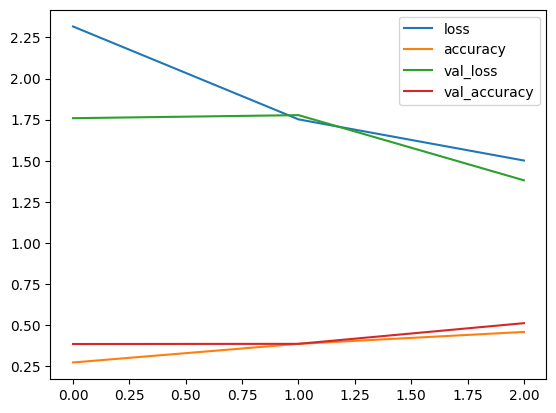

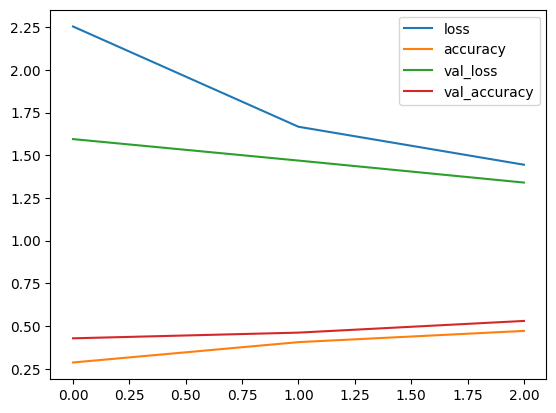

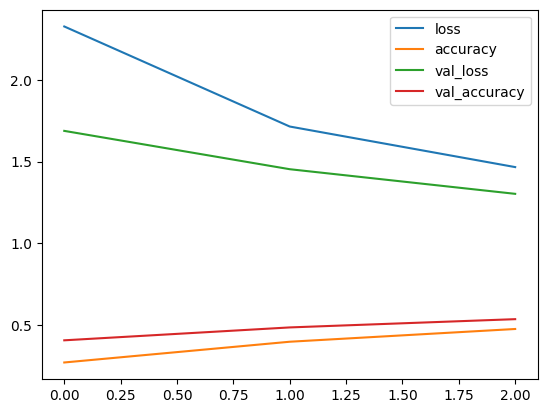

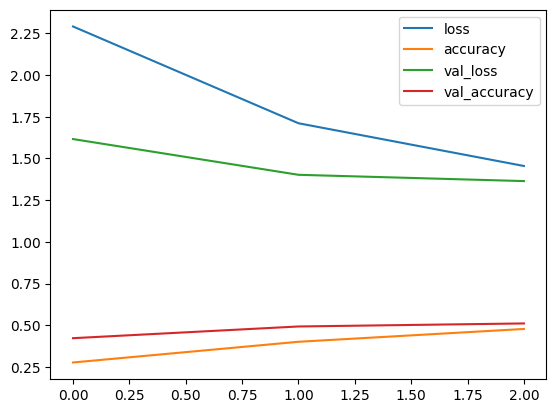

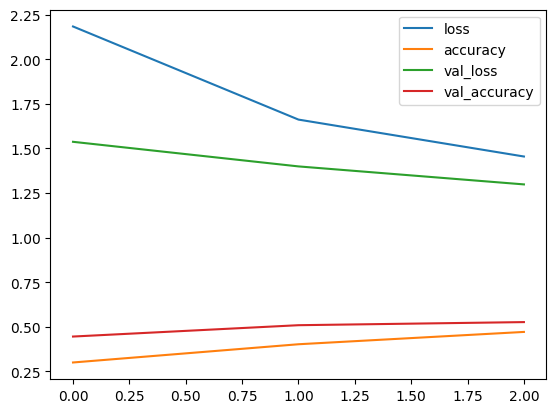

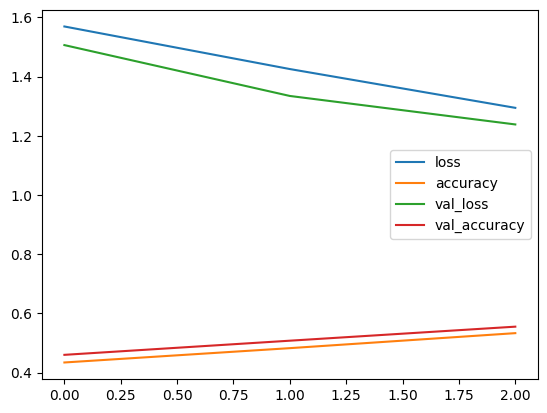

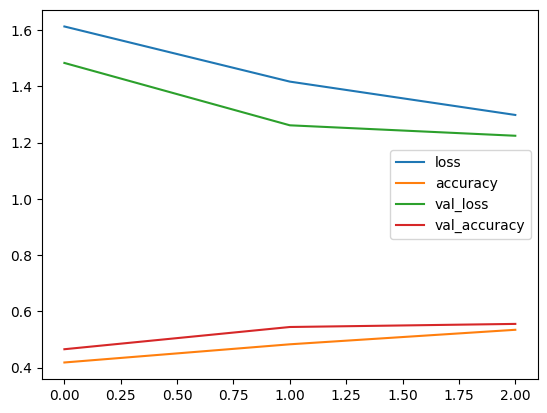

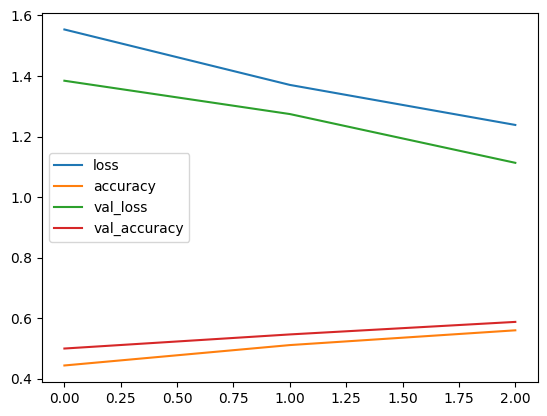

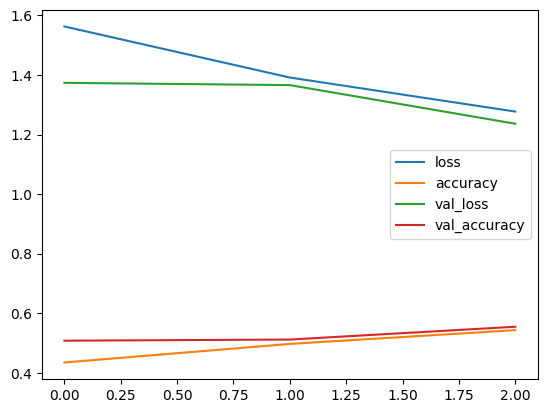

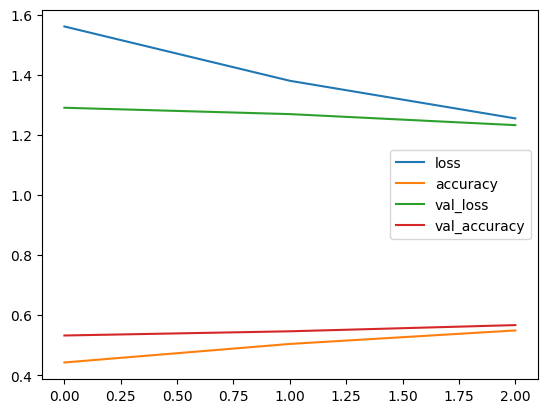

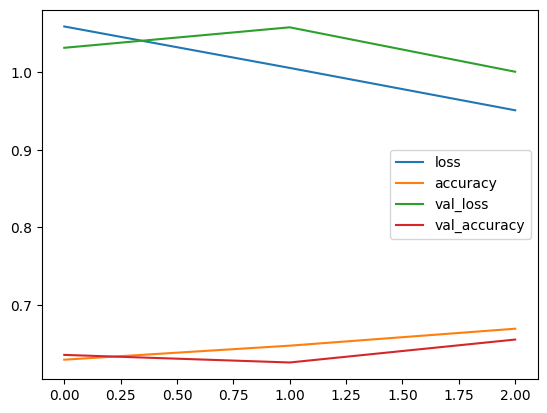

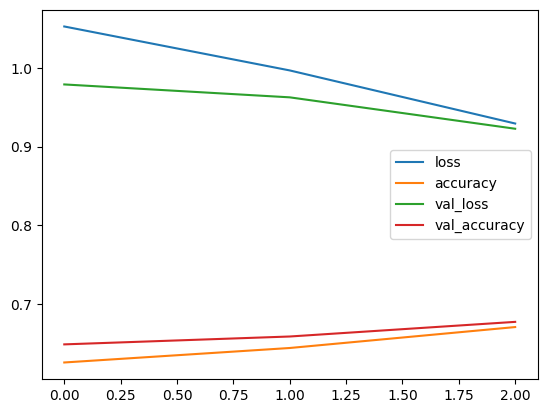

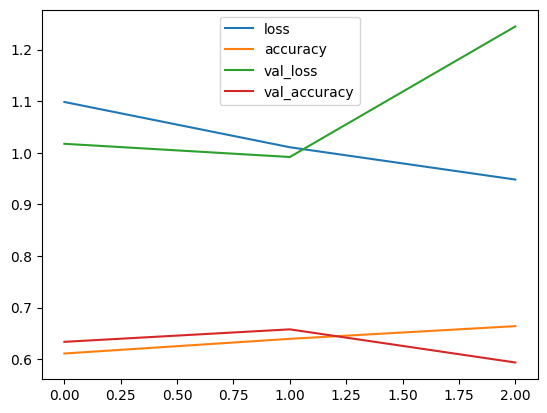

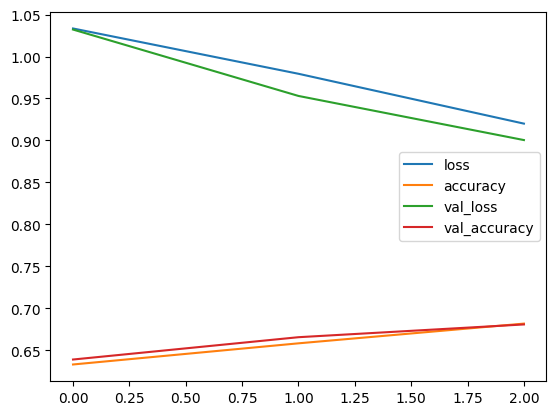

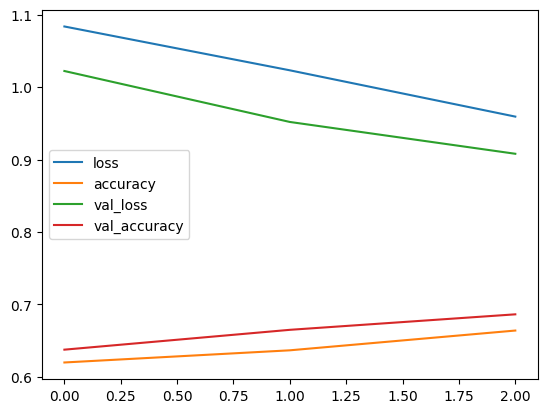

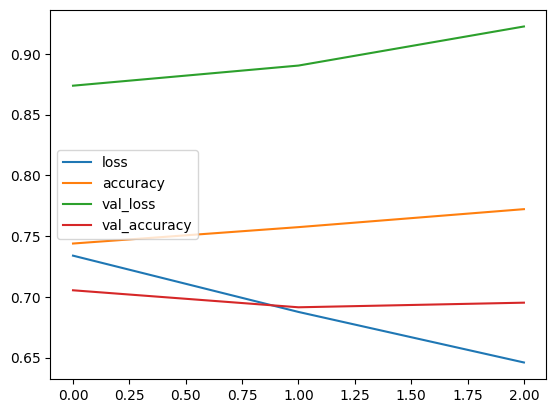

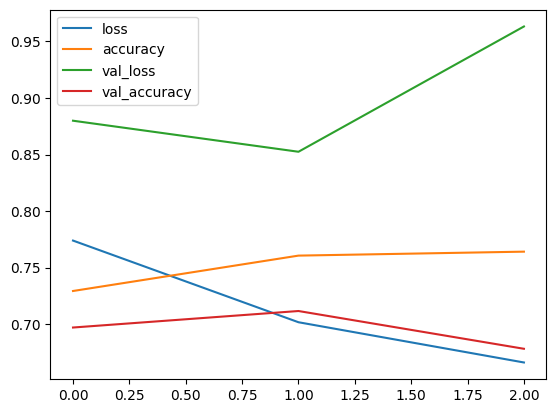

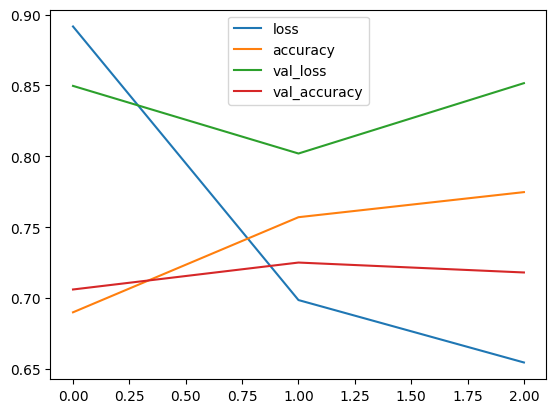

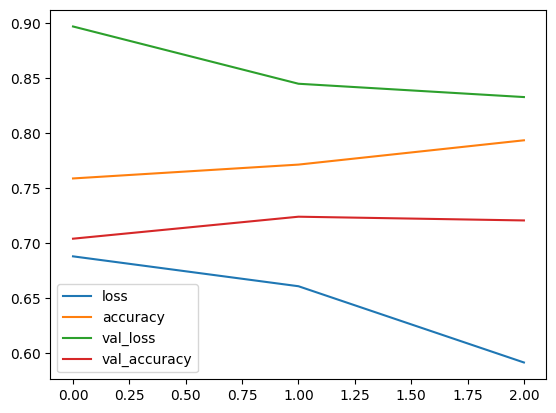

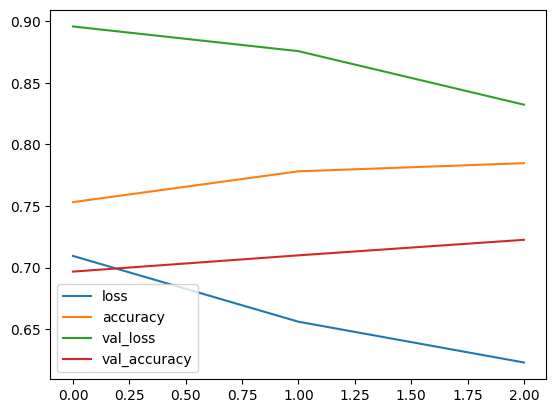

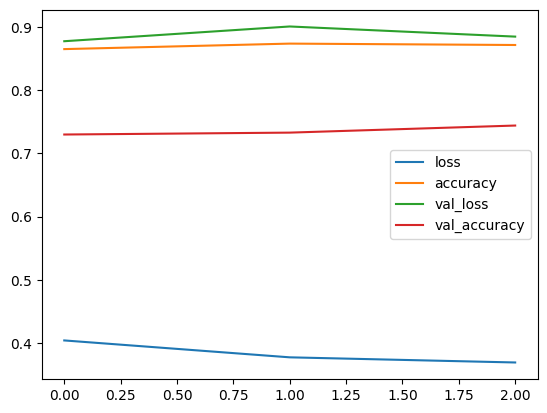

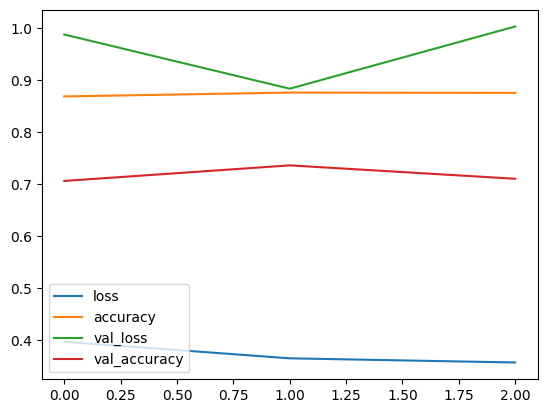

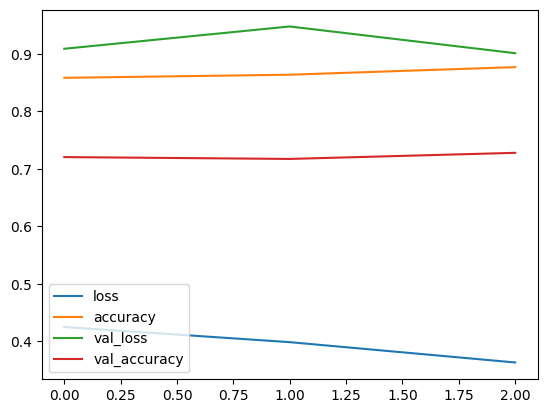

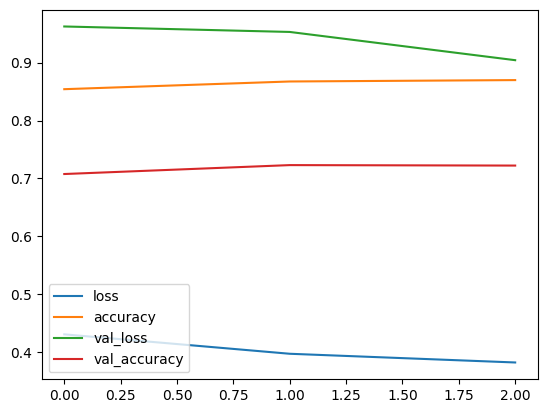

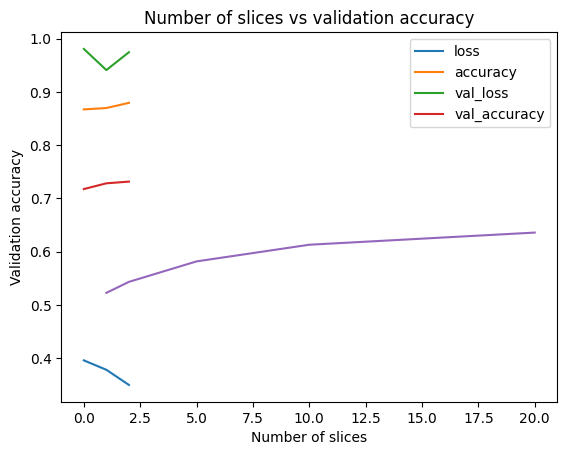

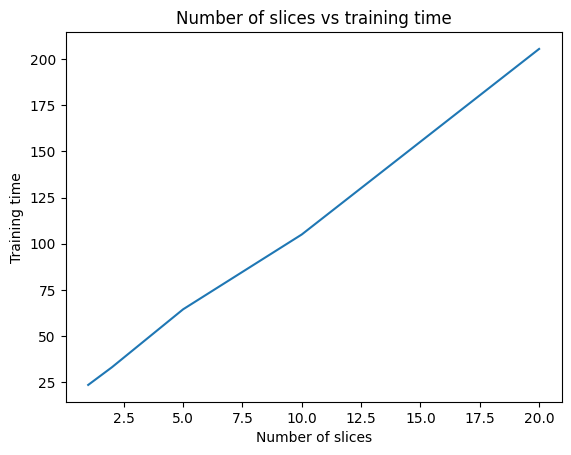

In [ ]:
# plot num_slices against validation accuracy
# plot num_slices against training time

slices = [1, 2, 5, 10, 20]
avg_val_accs = []
avg_train_times = []
for i in slices:
    temp_num_slices = i
    start_time = time.time()
    shard_models, validation_accuracies_temp = train_all_shards(CIFAR_partition_num, num_epochs, temp_num_slices)
    avg_train_times.append((time.time() - start_time)/CIFAR_partition_num)
    avg_val_accs.append(np.mean(validation_accuracies_temp))



plt.plot(slices, avg_val_accs)
plt.xlabel("Number of slices")
plt.ylabel("Validation accuracy")
plt.title("Number of slices vs validation accuracy")
plt.show()

plt.plot(slices, avg_train_times)
plt.xlabel("Number of slices")
plt.ylabel("Training time")
plt.title("Number of slices vs training time")
plt.show()

#### Plot

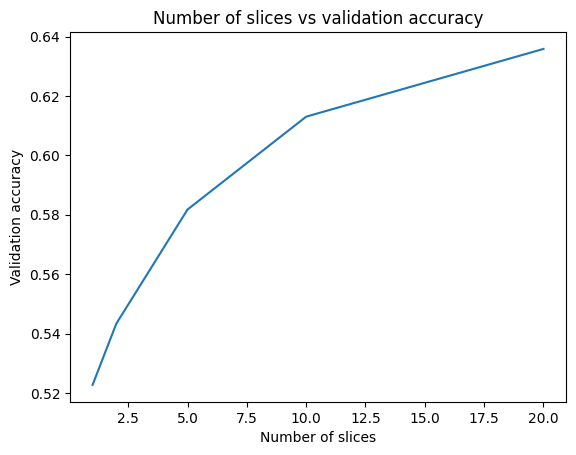

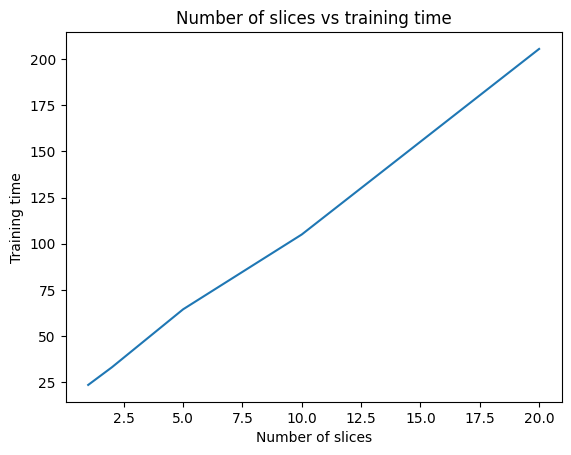

In [ ]:
plt.plot(slices, avg_val_accs)
plt.xlabel("Number of slices")
plt.ylabel("Validation accuracy")
plt.title("Number of slices vs validation accuracy")
plt.show()

plt.plot(slices, avg_train_times)
plt.xlabel("Number of slices")
plt.ylabel("Training time")
plt.title("Number of slices vs training time")
plt.show()

### Predictions

In [ ]:
train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, CIFAR_partition_num)

validation_accuracies = []
# train all shards

shard_models = train_all_shards(CIFAR_partition_num, num_epochs, num_slices)
print("validation_accuracies", validation_accuracies)

# Predictions of each shard model
shard_models_prediction_matrix = predict_all_shards(shard_models, CIFAR_partition_num)

pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies, CIFAR_partition_num)
test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)
print("test_acc", test_acc)
print("Weighted test accuracy:", weighted_test_acc)

# remove 2000 data points from shard 3 slice 4
# remove 2000 data points from shard 1 slice 2
# remove a lot from shard 2
# remove 2000 data points from shard 2 slice 3
# remove 2000 data points from shard 2 slice 4
# remove 2000 data points from shard 2 slice 0
# remove 2000 data points from shard 2 slice 2

# main()

## Machine Unlearning

### Functions

In [ ]:
# edit a slice in shard 4
# slice_num = 3
# change slice3 to slice3[20:]

# num_slices = 5
# change_slice_num = 3
# change_shard_num = 4
# train_data_CIFAR_partitioned_revised = train_data_CIFAR_partitioned[:]

# slice_size = train_data_CIFAR_partitioned_revised[change_shard_num][0].shape[0] // num_slices
# rm_slice_index_start = slice_size * (change_slice_num-1)
# rm_slice_index_end = slice_size * (change_slice_num-1)+20
# train_data_CIFAR_partitioned_revised[change_shard_num] = (np.delete(train_data_CIFAR_partitioned_revised[change_shard_num][0], range(rm_slice_index_start, rm_slice_index_end), axis=0), np.delete(train_data_CIFAR_partitioned_revised[change_shard_num][1], range(rm_slice_index_start, rm_slice_index_end), axis=0), np.delete(train_data_CIFAR_partitioned_revised[change_shard_num][2], range(rm_slice_index_start, rm_slice_index_end), axis=0))
# generalize above into a function
def remove_indices_from_slice(shard_num, slice_num, num_slices, start_index, end_index):
    train_data_CIFAR_partitioned_revised = train_data_CIFAR_partitioned[:]
    slice_size = train_data_CIFAR_partitioned_revised[shard_num][0].shape[0] // num_slices
    size_shard = train_data_CIFAR_partitioned_revised[shard_num][0].shape[0]
    rm_slice_index_start = slice_size * (slice_num-1) + start_index
    rm_slice_index_end = slice_size * (slice_num-1) + end_index
    if rm_slice_index_end > size_shard:
        diff = rm_slice_index_end - size_shard
        rm_slice_index_end = size_shard
        rm_slice_index_start = rm_slice_index_start - diff
        if rm_slice_index_start < 0:
            undeleted = 0 - rm_slice_index_start
            rm_slice_index_start = 0
            print("ERROR: rm_slice_index_start < 0")
            print("Slices undeleted", undeleted)
    train_data_CIFAR_partitioned_revised[shard_num] = (np.delete(train_data_CIFAR_partitioned_revised[shard_num][0], range(rm_slice_index_start, rm_slice_index_end), axis=0), np.delete(train_data_CIFAR_partitioned_revised[shard_num][1], range(rm_slice_index_start, rm_slice_index_end), axis=0), np.delete(train_data_CIFAR_partitioned_revised[shard_num][2], range(rm_slice_index_start, rm_slice_index_end), axis=0))
    return train_data_CIFAR_partitioned_revised

def remove_indices_from_shard(shard_num, start_index, end_index, num_slices):
    train_data_CIFAR_partitioned_revised = train_data_CIFAR_partitioned[:]
    start_slice_num = start_index // (train_data_CIFAR_partitioned_revised[shard_num][0].shape[0] // num_slices)
    train_data_CIFAR_partitioned_revised[shard_num] = (np.delete(train_data_CIFAR_partitioned_revised[shard_num][0], range(start_index, end_index), axis=0), np.delete(train_data_CIFAR_partitioned_revised[shard_num][1], range(start_index, end_index), axis=0), np.delete(train_data_CIFAR_partitioned_revised[shard_num][2], range(start_index, end_index), axis=0))
    return train_data_CIFAR_partitioned_revised, start_slice_num

def rerun_shard_from_slice(revised_training_data, shard_num, checkpoint_num, num_epochs=5, num_slices=5, validation_accuracies=[]):
    validation_accuracies_new = validation_accuracies[:]
    shard_CIFAR_kaggle_model, shard_CIFAR_kaggle_model_history, validation_accuracies_new \
    = train_CIFAR_kaggle_model_SISA(revised_training_data[shard_num][0], revised_training_data[shard_num][2], CIFAR_val_images, CIFAR_val_labels_one_hot, num_epochs=num_epochs, num_slices=num_slices, load_checkpoint=True, checkpoint_num=checkpoint_num, validation_accuracies=validation_accuracies_new, shard_num=shard_num)

    pd.DataFrame(shard_CIFAR_kaggle_model_history.history).plot()

    return shard_CIFAR_kaggle_model, validation_accuracies_new


def unlearn_data(remove_indices, num_epochs=5, num_slices=5, validation_accuracies=[], num_shards=5):
    # remove_indices = [(shard_num, slice_num, start_index, end_index), ...]
    # remove_indices = [(4, 3, 0, 20), (2, 4, 100, 200)]
    start_time = time.time()
    shard_models_revised = shard_models[:]
    validation_accuracies_new = validation_accuracies[:]
    remove_from_shard_dict = {} # key: shard_num, value: [(start_index, end_index), ...]
    for i in range(len(remove_indices)):
        shard_num, slice_num, start_index, end_index = remove_indices[i]
        if shard_num >= num_shards:
            print("ERROR: shard_num >= num_shards")
            print("shard_num", shard_num)
            print("num_shards", num_shards)
            shard_num = num_shards - 1
            print("shard_num set to", shard_num)

        if slice_num >= num_slices:
            print("ERROR: slice_num >= num_slices")
            print("slice_num", slice_num)
            print("num_slices", num_slices)

            slice_num = num_slices - 1
            print("slice_num set to", slice_num)

        print("Unlearning shard", shard_num, "slice", slice_num, "start_index", start_index, "end_index", end_index)
        slice_size = train_data_CIFAR_partitioned[shard_num][0].shape[0] // num_slices

        start_index = slice_size * (slice_num) + start_index
        end_index = slice_size * (slice_num) + end_index
        if end_index > train_data_CIFAR_partitioned[shard_num][0].shape[0]:
            diff = end_index - train_data_CIFAR_partitioned[shard_num][0].shape[0]+1
            print("end index > shard size")
            print("diff", diff)
            print("loop to beginning of shard")

            end_index = train_data_CIFAR_partitioned[shard_num][0].shape[0]
            start_index = start_index - diff
            if start_index < 0:
                undeleted = 0 - start_index
                start_index = 0
                print("ERROR: start_index < 0")
                print("Slices undeleted", undeleted)

        if shard_num in remove_from_shard_dict:
            remove_from_shard_dict[shard_num].append((start_index, end_index))
        else:
            remove_from_shard_dict[shard_num] = [(start_index, end_index)]

    for shard_num in remove_from_shard_dict:
        start_index = 0
        end_index = 0
        for i in range(len(remove_from_shard_dict[shard_num])):
            start_index, end_index = remove_from_shard_dict[shard_num][i]
            train_data_CIFAR_partitioned_revised, start_slice_num = remove_indices_from_shard(shard_num, start_index, end_index, num_slices)
            reruned_model, validation_accuracies_new = rerun_shard_from_slice(train_data_CIFAR_partitioned_revised, shard_num, checkpoint_num=start_slice_num-1, num_epochs=num_epochs, num_slices=num_slices, validation_accuracies=validation_accuracies_new)
            start_index = end_index
            shard_models_revised[shard_num] = reruned_model

        # train_data_CIFAR_partitioned_revised = remove_indices_from_slice(shard_num, slice_num, num_slices, start_index, end_index)

        # reruned_model, validation_accuracies_new = rerun_shard_from_slice(train_data_CIFAR_partitioned_revised, shard_num, checkpoint_num=slice_num-1, num_epochs=num_epochs, num_slices=num_slices, validation_accuracies=validation_accuracies_new)
        # shard_models_revised[shard_num] = reruned_model

    ensemble_prediction_matrix_new = predict_all_shards(shard_models_revised, num_shards)

    ensemble_prediction, weighted_ensemble_prediction_new = ensemble_predict(ensemble_prediction_matrix_new, validation_accuracies_new, num_shards)
    test_acc_new, weighted_test_acc_new = get_accuracy(ensemble_prediction, CIFAR_test_labels, weighted_ensemble_prediction_new)
    print("Unlearning time for removing", time.time() - start_time)
    print("test_acc_new", test_acc_new)
    print("test_acc_old", test_acc)
    print("Weighted test accuracy old:", weighted_test_acc)
    print("Weighted test accuracy new:", weighted_test_acc_new)


    return shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new

### Test1

In [ ]:
shard_models_revised, train_data_CIFAR_partitioned_revised = \
unlearn_data([(4, 3, 0, 20), (2, 4, 100, 200)], num_epochs=5, num_slices=5)

# remove 1000 data points from shard 1 slice 3
# remove 2000 data points from shard 3 slice 4
# remove 2000 data points from shard 4 slice 3
# remove 2000 data points from shard 4 slice 4

shard_models_revised, train_data_CIFAR_partitioned_revised = \
unlearn_data([(1, 3, 0, 1000), (3, 4, 0, 2000), (4, 3, 0, 2000), (4, 4, 0, 2000)], num_epochs=5, num_slices=5)


###Test2

In [ ]:
# remove 2000 data points from shard 3 slice 4
# remove 2000 data points from shard 1 slice 2
# remove a lot from shard 2
# remove 2000 data points from shard 2 slice 3
# remove 2000 data points from shard 2 slice 4
# remove 2000 data points from shard 2 slice 0
# remove 2000 data points from shard 2 slice 2

shard_models_revised, train_data_CIFAR_partitioned_revised = \
unlearn_data([(3, 4, 0, 2000), (1, 2, 0, 2000), (2, 0, 0, 2000), (2, 2, 0, 2000), (2, 3, 0, 2000), (2, 4, 0, 2000)], num_epochs=5, num_slices=5)


### Test num_slices against unlearning time and accuracy loss

#### Pt1 Training

In [ ]:
# plot num_slices against unlearning time and accuracy loss

slices = [1, 2, 5, 10, 20]
unlearning_times = []
acc_losses = []
weighted_acc_losses = []
# remove 2000 images from shard 2 slice 2, 1500 images from shard 3 slice 3, 1000 images from shard 4 slice 1


train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, CIFAR_partition_num)



temp_num_slices = 1
shard_models, validation_accuracies_temp = train_all_shards(CIFAR_partition_num, num_epochs, temp_num_slices)
shard_models_prediction_matrix = predict_all_shards(shard_models, CIFAR_partition_num)
pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies_temp, CIFAR_partition_num)
test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)





#### Pt2 Unlearning

shard_num 2
slice_num 0
Unlearning shard 2 slice 0 start_index 0 end_index 2000
size_slice 14668
Load checkpoint -1
retrain slice number 0
Epoch 1/3
459/459 [==============================] - 10s 13ms/step - loss: 2.1029 - accuracy: 0.3151 - val_loss: 1.5339 - val_accuracy: 0.4428
Epoch 2/3
459/459 [==============================] - 5s 10ms/step - loss: 1.5204 - accuracy: 0.4594 - val_loss: 1.4610 - val_accuracy: 0.4912
Epoch 3/3
459/459 [==============================] - 6s 12ms/step - loss: 1.3016 - accuracy: 0.5334 - val_loss: 1.8292 - val_accuracy: 0.5216
checkpoint_num -1
old validation accuracy 0.5113999843597412
new validation accuracy 0.5113999843597412
shard_num 2
slice_num 0
Unlearning shard 2 slice 0 start_index 10 end_index 1500
size_slice 15178
Load checkpoint -1
retrain slice number 0
Epoch 1/3
475/475 [==============================] - 10s 13ms/step - loss: 2.0635 - accuracy: 0.3203 - val_loss: 1.4243 - val_accuracy: 0.4836
Epoch 2/3
475/475 [============================

ValueError: ignored

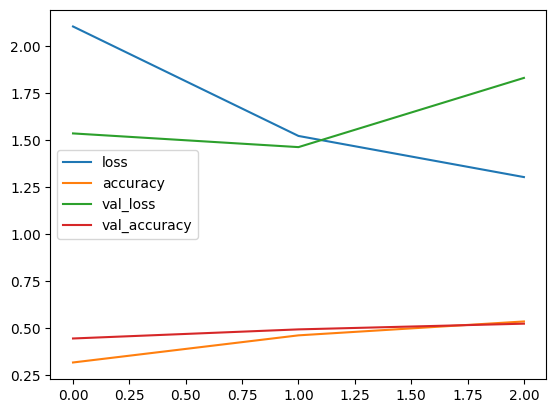

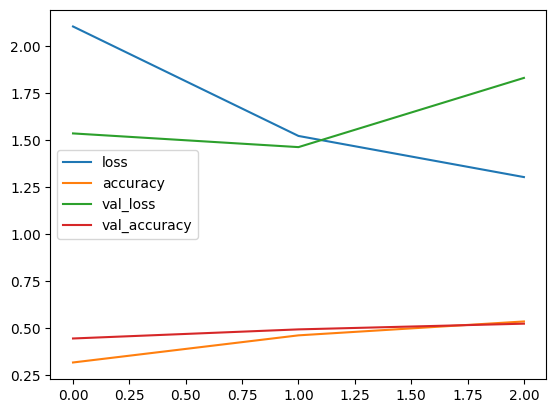

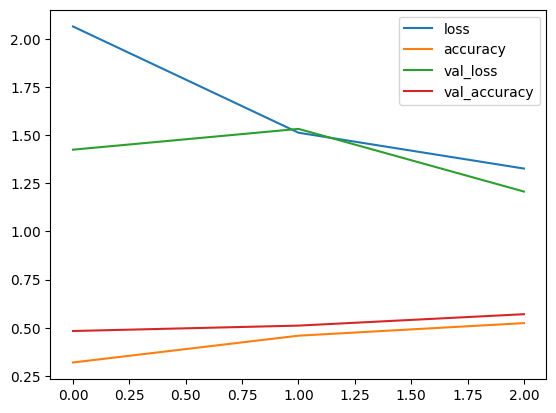

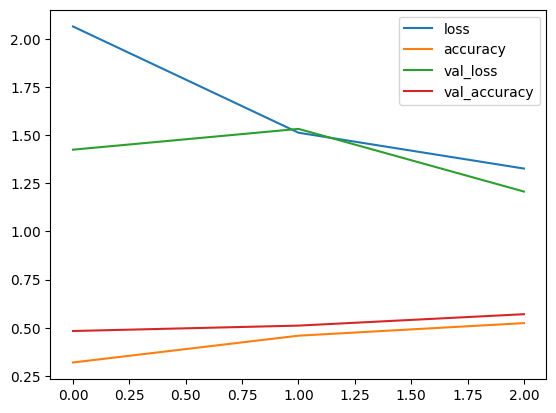

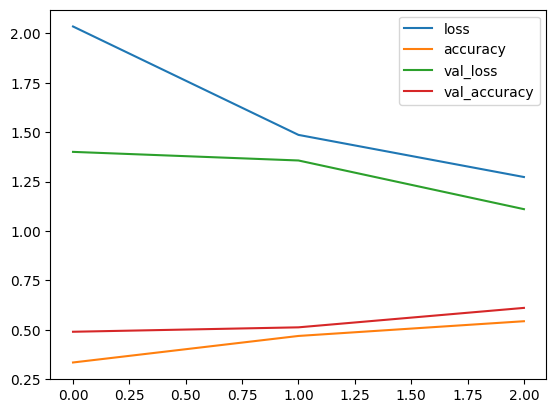

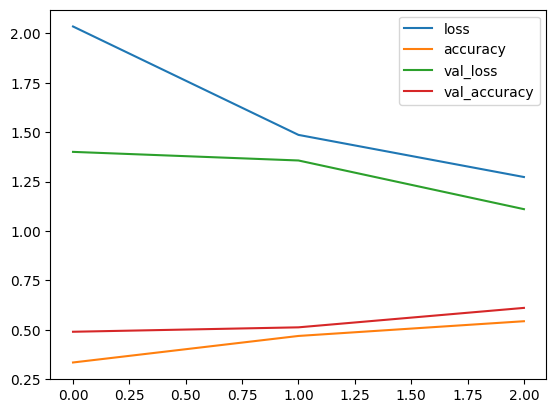

In [ ]:
unlearning_start_time = time.time()
# remove 2000 images from shard 2 slice 2
shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new = \
unlearn_data([(2, 2, 0, 2000), (3, 3, 10, 1500), (4, 1, 500, 1000)], num_epochs=num_epochs, num_slices=temp_num_slices, validation_accuracies=validation_accuracies_temp, num_shards=CIFAR_partition_num)
unlearning_times.append(time.time() - unlearning_start_time)
acc_losses.append(test_acc - test_acc_new)
weighted_acc_losses.append(weighted_test_acc - weighted_test_acc_new)

plt.plot(slices, unlearning_times)
plt.xlabel("Number of slices")
plt.ylabel("Unlearning time")
plt.title("Number of slices vs unlearning time")
plt.show()

# plot num_slices against accuracy loss and weighted accuracy loss
# label lines with accuracy loss and weighted accuracy loss
plt.plot(slices, acc_losses, label="Accuracy loss")
plt.plot(slices, weighted_acc_losses, label="Weighted accuracy loss")
plt.xlabel("Number of slices")
plt.ylabel("Accuracy loss")
plt.title("Number of slices vs accuracy loss")
plt.legend()
plt.show()

#### Full tests

#### predictions

In [ ]:
# training part of above

slices = [1, 2, 3, 5, 10]

train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, CIFAR_partition_num)

shard_models_per_test = []
test_accs = []
weighted_test_accs = []
validation_accs_per_test = []

for i in slices:
    temp_num_slices = i
    shard_models, validation_accuracies_temp = train_all_shards(CIFAR_partition_num, num_epochs, temp_num_slices)
    validation_accs_per_test.append(validation_accuracies_temp)

    shard_models_prediction_matrix = predict_all_shards(shard_models, CIFAR_partition_num)
    pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies_temp, CIFAR_partition_num)
    test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)
    test_accs.append(test_acc)
    weighted_test_accs.append(weighted_test_acc)
    shard_models_per_test.append(shard_models)


size_slice 16666
Training slice number 0
Epoch 1/3
521/521 [==============================] - 9s 9ms/step - loss: 2.0724 - accuracy: 0.3227 - val_loss: 1.4711 - val_accuracy: 0.4696
Epoch 2/3
521/521 [==============================] - 4s 8ms/step - loss: 1.4782 - accuracy: 0.4642 - val_loss: 1.2543 - val_accuracy: 0.5488
Epoch 3/3
521/521 [==============================] - 4s 8ms/step - loss: 1.2759 - accuracy: 0.5439 - val_loss: 1.1594 - val_accuracy: 0.5862
size_slice 16666
Training slice number 0
Epoch 1/3
521/521 [==============================] - 8s 9ms/step - loss: 2.0527 - accuracy: 0.3283 - val_loss: 1.5656 - val_accuracy: 0.4472
Epoch 2/3
521/521 [==============================] - 4s 8ms/step - loss: 1.4684 - accuracy: 0.4710 - val_loss: 1.4616 - val_accuracy: 0.5092
Epoch 3/3
521/521 [==============================] - 4s 8ms/step - loss: 1.2361 - accuracy: 0.5579 - val_loss: 1.1993 - val_accuracy: 0.5746
size_slice 16666
Training slice number 0
Epoch 1/3
521/521 [============

Shard 1 accuracy: 0.5926


Shard 2 accuracy: 0.5874
size_slice 5555
Training slice number 0
(5555, 32, 32, 3)
Epoch 1/3
174/174 [==============================] - 6s 13ms/step - loss: 2.4683 - accuracy: 0.2581 - val_loss: 1.7400 - val_accuracy: 0.3874
Epoch 2/3
174/174 [==============================] - 2s 10ms/step - loss: 1.9252 - accuracy: 0.3573 - val_loss: 1.5159 - val_accuracy: 0.4570
Epoch 3/3
174/174 [==============================] - 2s 10ms/step - loss: 1.6514 - accuracy: 0.4238 - val_loss: 1.4885 - val_accuracy: 0.4738
Training slice number 1
(5555, 32, 32, 3)
Epoch 1/3
174/174 [==============================] - 2s 11ms/step - loss: 1.5854 - accuracy: 0.4389 - val_loss: 1.4740 - val_accuracy: 0.4900
Epoch 2/3
174/174 [==============================] - 2s 11ms/step - loss: 1.4142 - accuracy: 0.4983 - val_loss: 1.2941 - val_accuracy: 0.5424
Epoch 3/3
174/174 [==============================] - 2s 10ms/step - loss: 1.2908 - accuracy: 0.5428 - val_loss: 1.2541 - val_accuracy: 0.5576
Training slice number 2

#### Unlearning

ERROR: slice_num >= num_slices
slice_num 2
num_slices 1
slice_num set to 0
Unlearning shard 1 slice 0 start_index 0 end_index 2000
ERROR: slice_num >= num_slices
slice_num 3
num_slices 1
slice_num set to 0
Unlearning shard 0 slice 0 start_index 10 end_index 1500
ERROR: slice_num >= num_slices
slice_num 1
num_slices 1
slice_num set to 0
Unlearning shard 2 slice 0 start_index 500 end_index 500
ERROR: slice_num >= num_slices
slice_num 2
num_slices 1
slice_num set to 0
Unlearning shard 2 slice 0 start_index 0 end_index 2000
ERROR: slice_num >= num_slices
slice_num 3
num_slices 1
slice_num set to 0
Unlearning shard 2 slice 0 start_index 10 end_index 2000
ERROR: slice_num >= num_slices
slice_num 4
num_slices 1
slice_num set to 0
Unlearning shard 2 slice 0 start_index 0 end_index 2000
size_slice 14666
checkpoint:  -1
retrain slice number 0
Epoch 1/3
459/459 [==============================] - 8s 9ms/step - loss: 2.1184 - accuracy: 0.3139 - val_loss: 1.5129 - val_accuracy: 0.4508
Epoch 2/3
459/

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


size_slice 2933
checkpoint:  1
Loaded after slice 1
retrain slice number 2
(2933, 32, 32, 3)
Epoch 1/3
92/92 [==============================] - 5s 17ms/step - loss: 1.6608 - accuracy: 0.4153 - val_loss: 1.4518 - val_accuracy: 0.4844
Epoch 2/3
92/92 [==============================] - 1s 13ms/step - loss: 1.4521 - accuracy: 0.4831 - val_loss: 1.6316 - val_accuracy: 0.4442
Epoch 3/3
92/92 [==============================] - 1s 13ms/step - loss: 1.3638 - accuracy: 0.4940 - val_loss: 1.4673 - val_accuracy: 0.4986
retrain slice number 3
(2933, 32, 32, 3)
Epoch 1/3
92/92 [==============================] - 1s 14ms/step - loss: 1.4630 - accuracy: 0.4859 - val_loss: 1.2959 - val_accuracy: 0.5368
Epoch 2/3
92/92 [==============================] - 1s 13ms/step - loss: 1.2573 - accuracy: 0.5496 - val_loss: 1.2543 - val_accuracy: 0.5588
Epoch 3/3
92/92 [==============================] - 1s 13ms/step - loss: 1.2045 - accuracy: 0.5721 - val_loss: 1.3178 - val_accuracy: 0.5412
retrain slice number 4
Epo

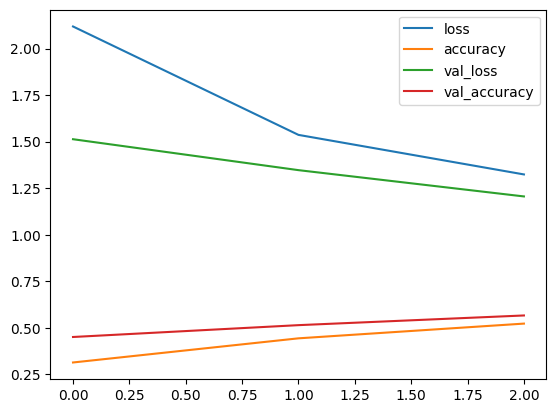

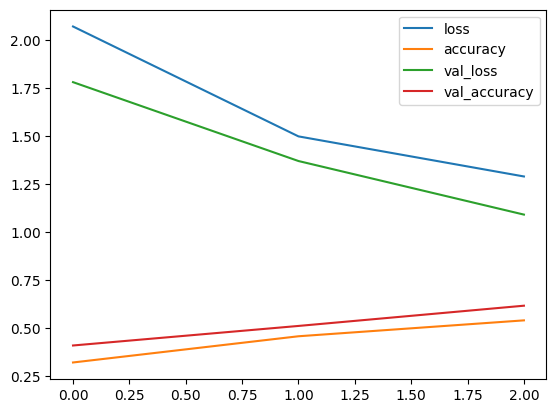

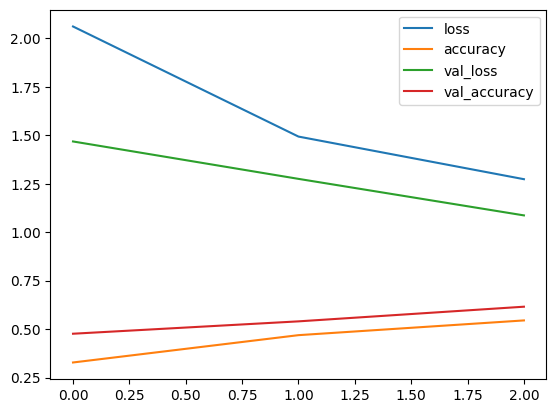

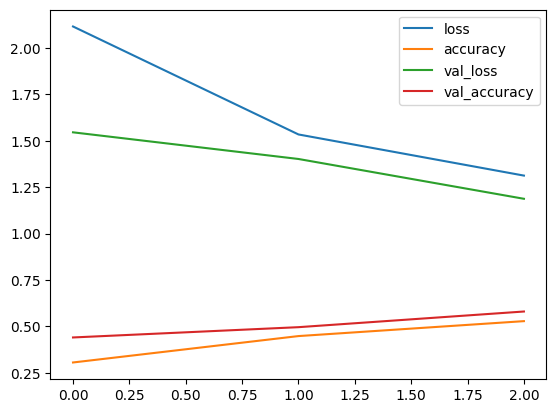

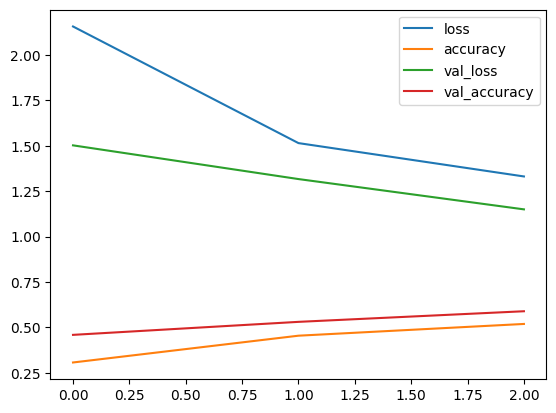

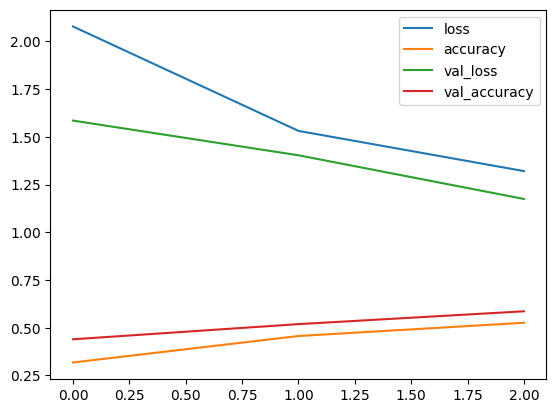

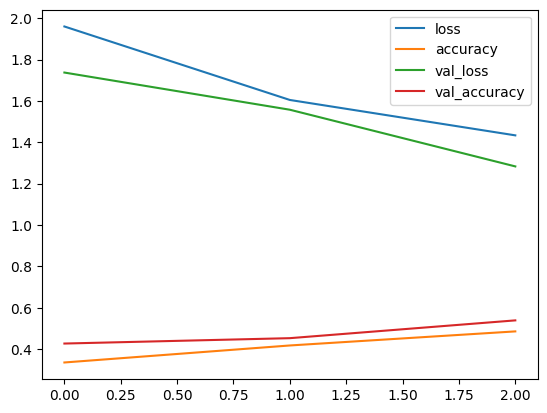

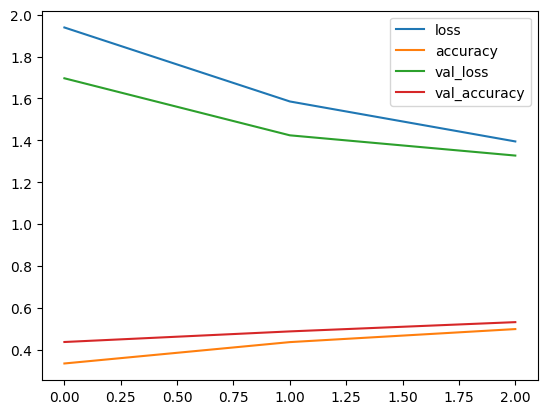

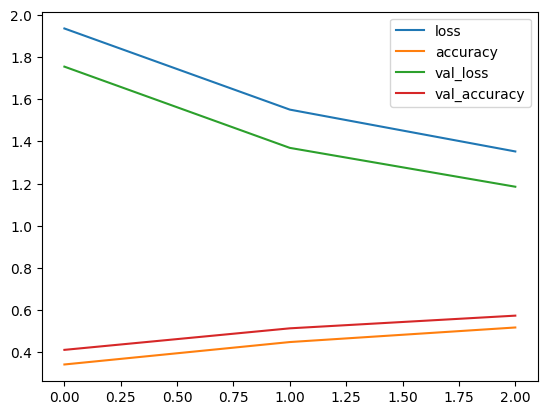

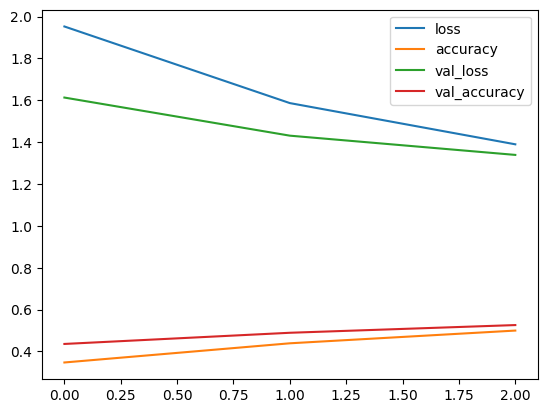

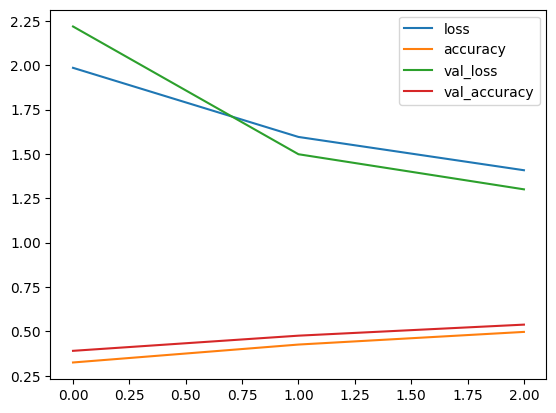

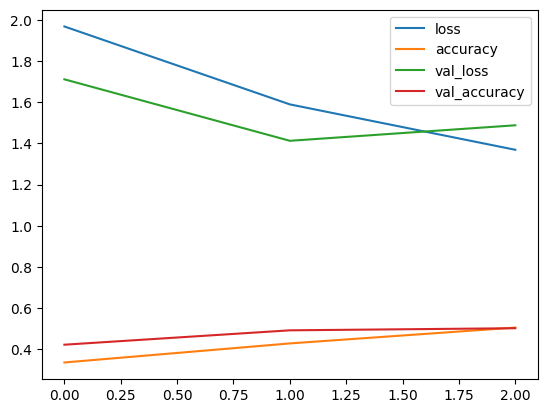

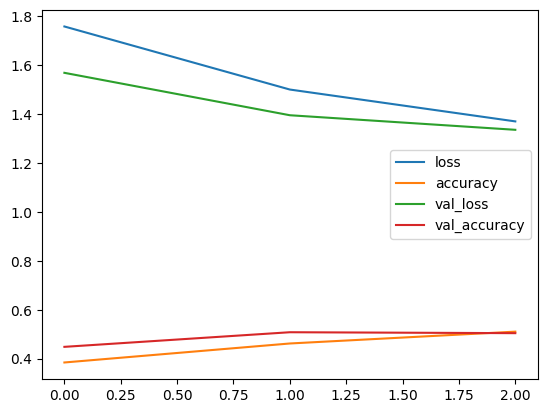

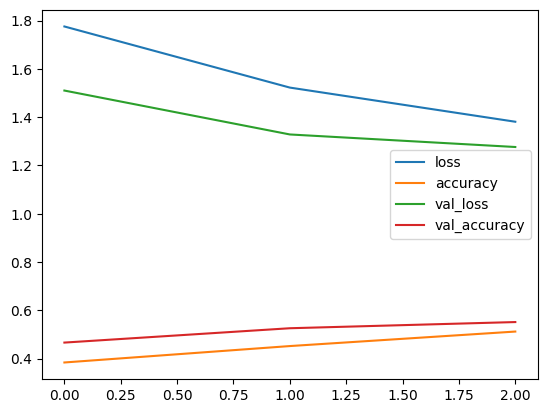

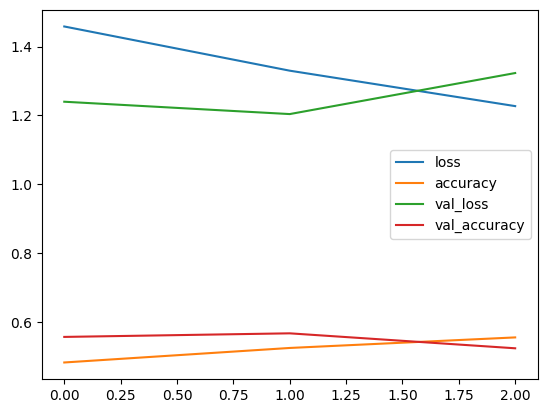

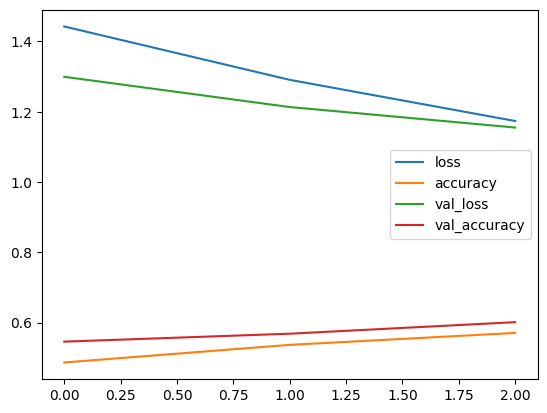

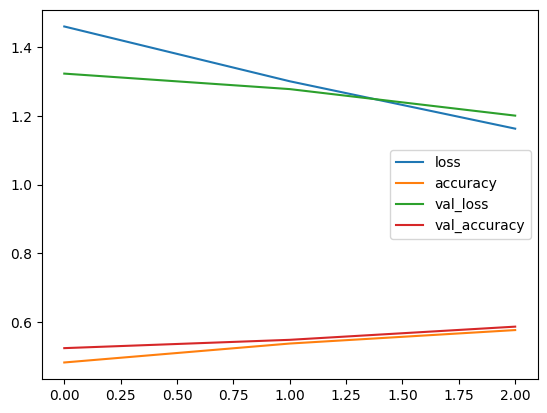

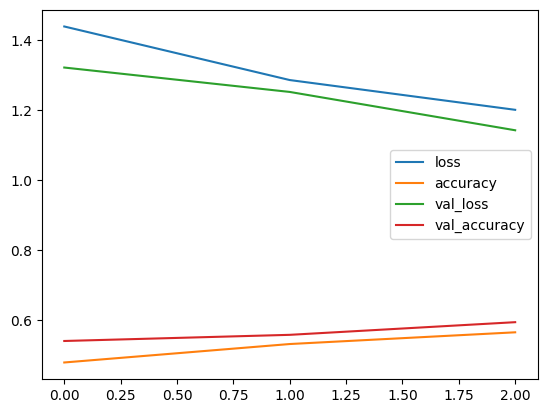

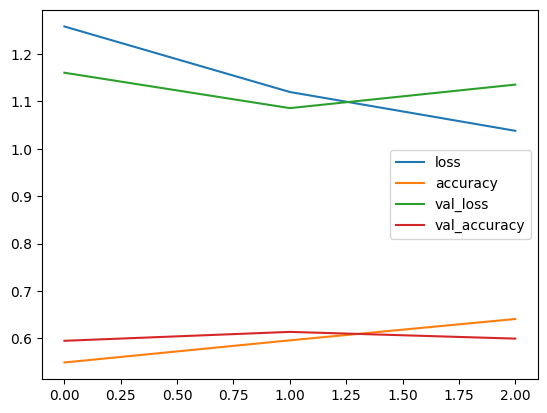

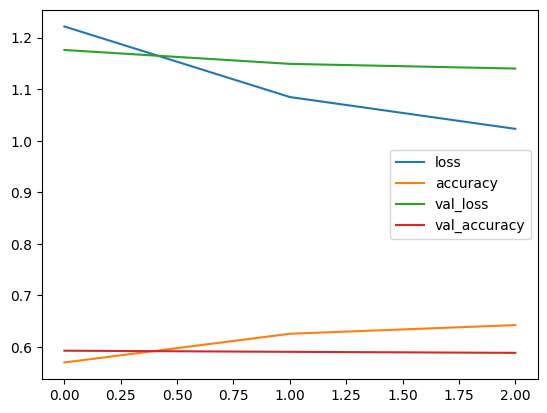

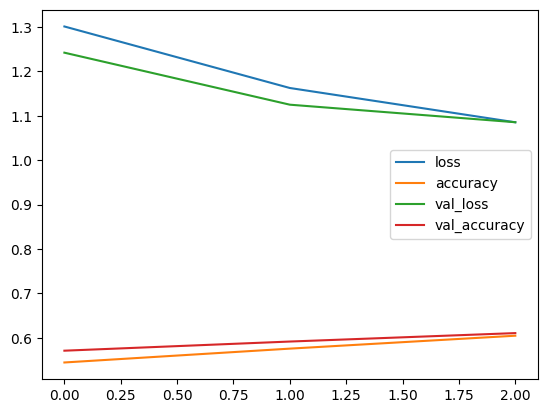

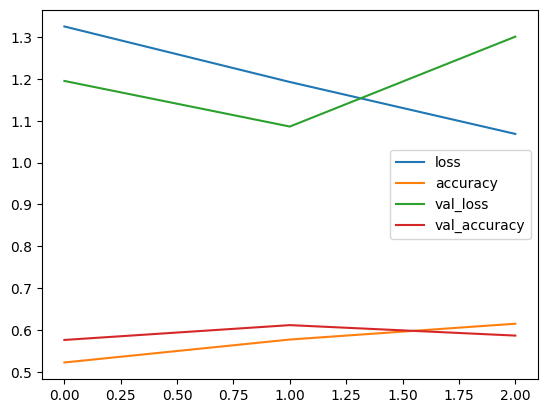

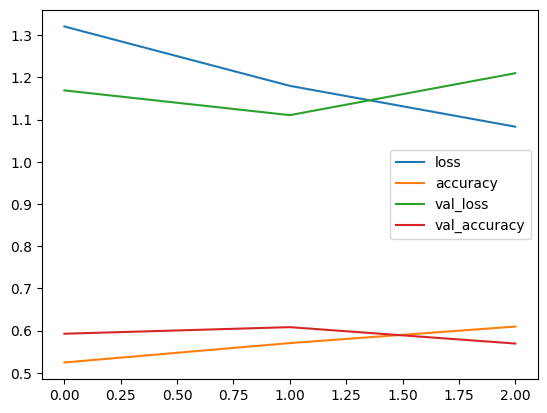

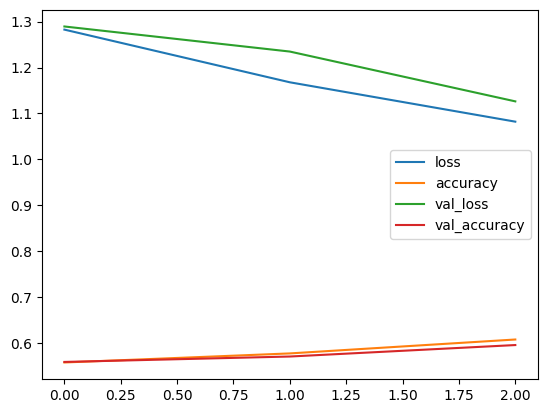

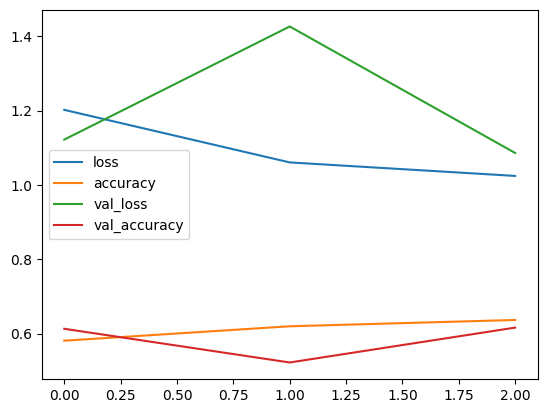

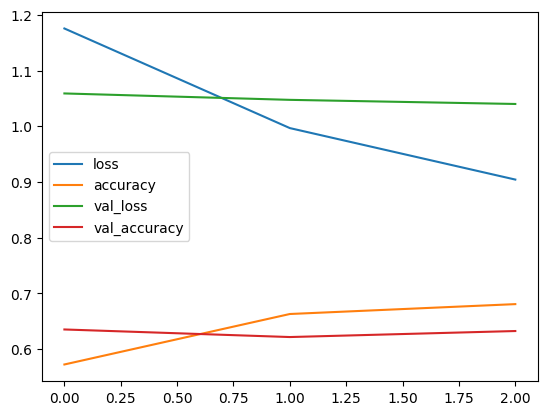

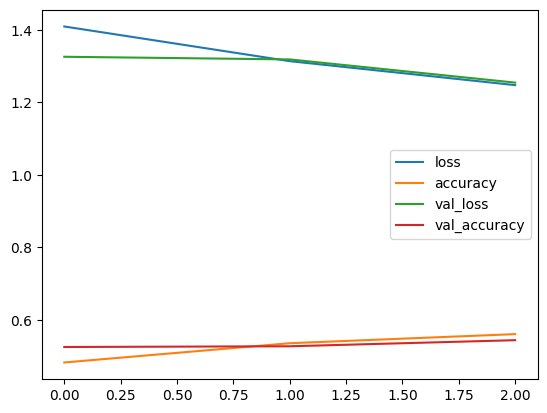

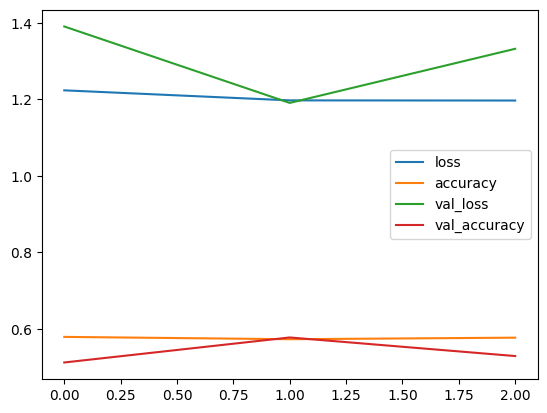

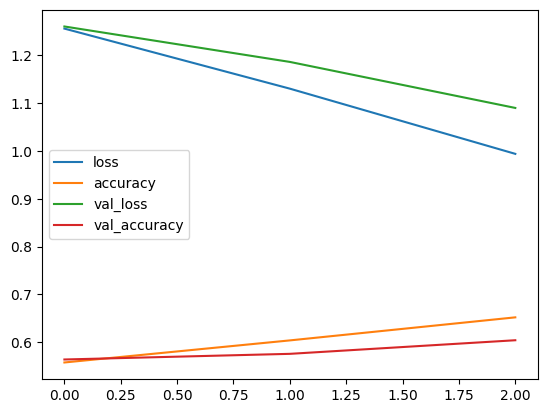

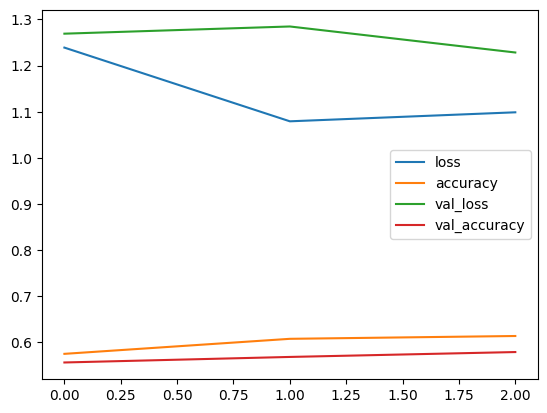

In [ ]:
# plot num_slices against unlearning time and accuracy loss
unlearning_times = []
acc_losses = []
weighted_acc_losses = []

# remove 2000 images from shard 1 slice 2, 1500 images from shard 0 slice 3, 500 images from shard 2 slice 1, 2000 images from shard 2 slice 2, 2000 images from shard 3 slice 3, 2000 images from shard 2 slice 4

for i, slice_n in enumerate(slices):
    temp_num_slices = slice_n
    # print(i)
    validation_accuracies_temp = validation_accs_per_test[i]

    unlearning_start_time = time.time()

    # remove 10000 images
    shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new = \
    unlearn_data([(1, 2, 0, 2000), (0, 3, 10, 1500), (2, 1, 500, 500), (2, 2, 0, 2000), (2, 3, 10, 2000), (2, 4, 0, 2000)], num_epochs=num_epochs, num_slices=temp_num_slices, validation_accuracies=validation_accuracies_temp, num_shards=CIFAR_partition_num)
    unlearning_times.append(time.time() - unlearning_start_time)
    acc_losses.append(test_accs[i] - test_acc_new)
    weighted_acc_losses.append(weighted_test_accs[i] - weighted_test_acc_new)


#### Plots

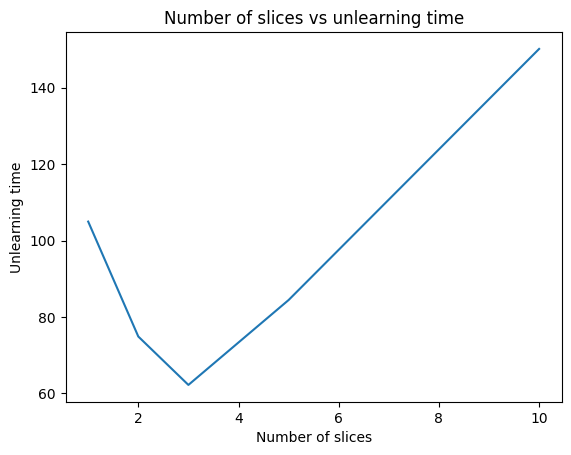

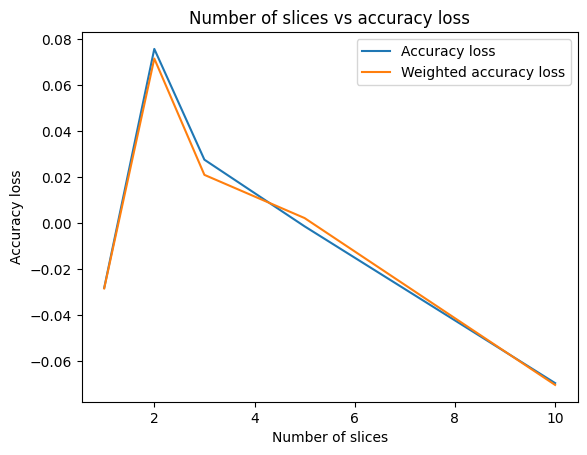

In [ ]:
plt.plot(slices, unlearning_times)
plt.xlabel("Number of slices")
plt.ylabel("Unlearning time")
plt.title("Number of slices vs unlearning time")
plt.show()

# plot num_slices against accuracy loss and weighted accuracy loss
# label lines with accuracy loss and weighted accuracy loss
plt.plot(slices, acc_losses, label="Accuracy loss")
plt.plot(slices, weighted_acc_losses, label="Weighted accuracy loss")
plt.xlabel("Number of slices")
plt.ylabel("Accuracy loss")
plt.title("Number of slices vs accuracy loss")
plt.legend()
plt.show()

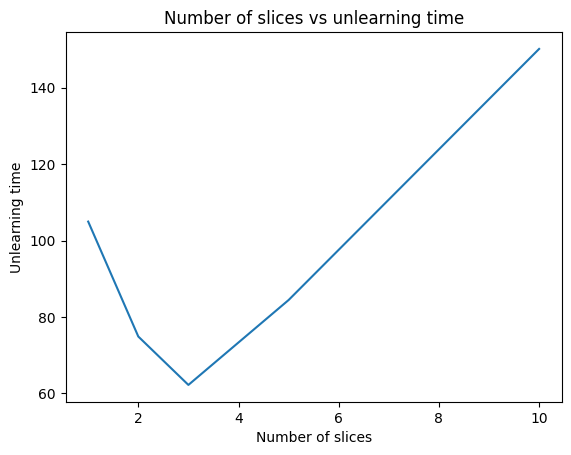

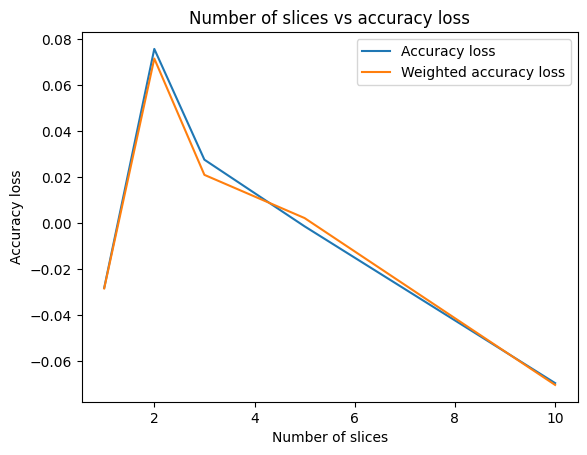

In [ ]:

plt.plot(slices, unlearning_times)
plt.xlabel("Number of slices")
plt.ylabel("Unlearning time")
plt.title("Number of slices vs unlearning time")
plt.show()

# plot num_slices against accuracy loss and weighted accuracy loss
# label lines with accuracy loss and weighted accuracy loss
plt.plot(slices, acc_losses, label="Accuracy loss")
plt.plot(slices, weighted_acc_losses, label="Weighted accuracy loss")
plt.xlabel("Number of slices")
plt.ylabel("Accuracy loss")
plt.title("Number of slices vs accuracy loss")
plt.legend()
plt.show()

#### Average slices

ERROR: shard_num >= num_shards
shard_num 5
num_shards 3
shard_num set to 2
Unlearning shard 2 slice 0 start_index 0 end_index 100
size_slice 16568
checkpoint:  -1
retrain slice number 0
Epoch 1/3
518/518 [==============================] - 9s 9ms/step - loss: 2.0120 - accuracy: 0.3384 - val_loss: 1.5071 - val_accuracy: 0.4750
Epoch 2/3
518/518 [==============================] - 4s 8ms/step - loss: 1.4694 - accuracy: 0.4703 - val_loss: 1.2563 - val_accuracy: 0.5526
Epoch 3/3
518/518 [==============================] - 5s 9ms/step - loss: 1.2655 - accuracy: 0.5489 - val_loss: 1.1180 - val_accuracy: 0.6004
shard_num 2
old validation accuracy 0.4973999857902527
new validation accuracy 0.6003999710083008
Shard 0 accuracy: 0.5238
Shard 1 accuracy: 0.58
Shard 2 accuracy: 0.5998
Unlearning time for removing 18.499945163726807
test_acc_new 0.6142
test_acc_old 0.5846
Weighted test accuracy old: 0.5838
Weighted test accuracy new: 0.6154
ERROR: shard_num >= num_shards
shard_num 5
num_shards 3
shard_

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Shard 1 accuracy: 0.58
Shard 2 accuracy: 0.6244
Unlearning time for removing 7.513808250427246
test_acc_new 0.6246
test_acc_old 0.5846
Weighted test accuracy old: 0.5838
Weighted test accuracy new: 0.6264


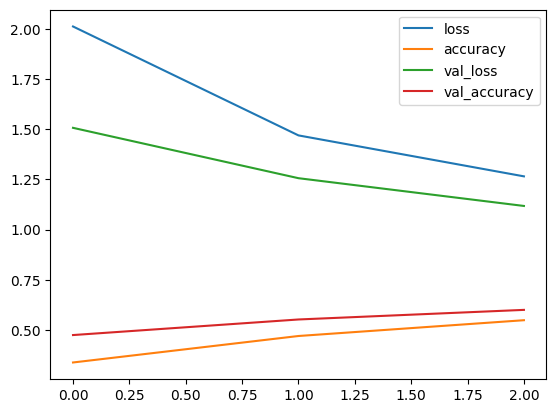

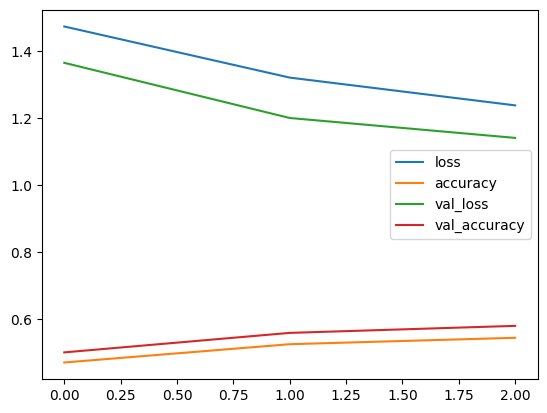

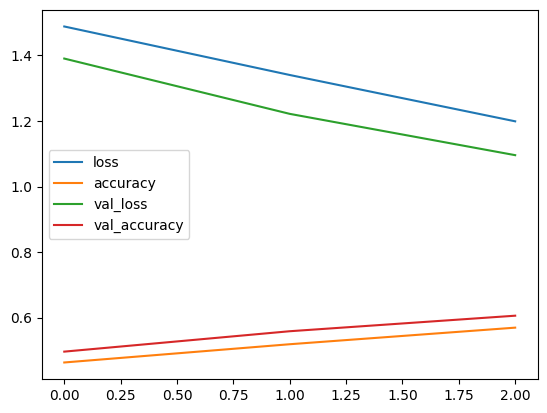

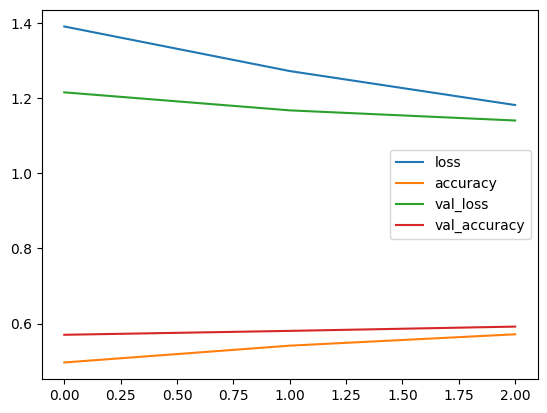

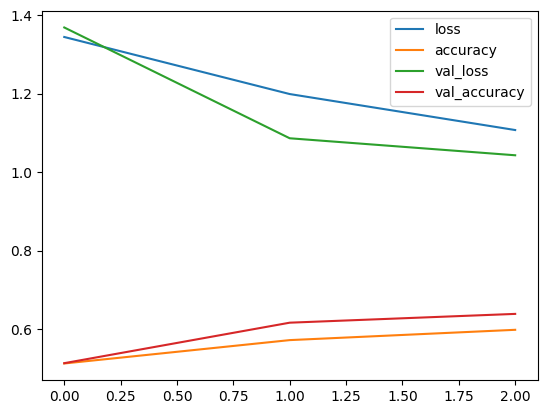

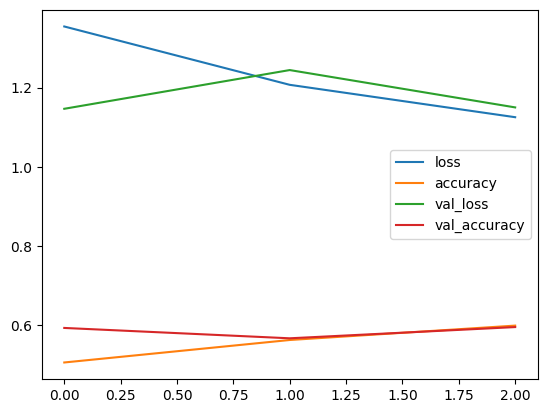

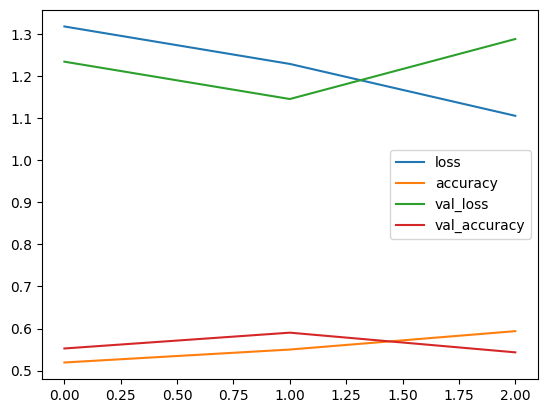

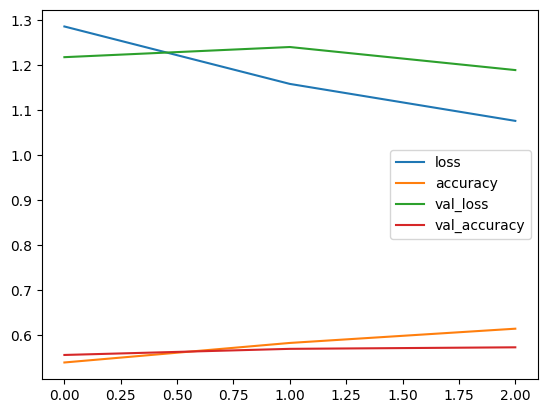

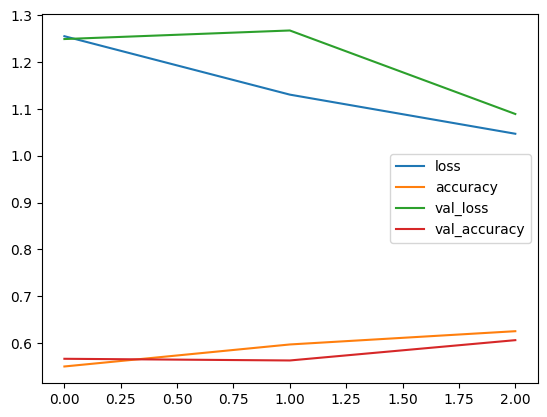

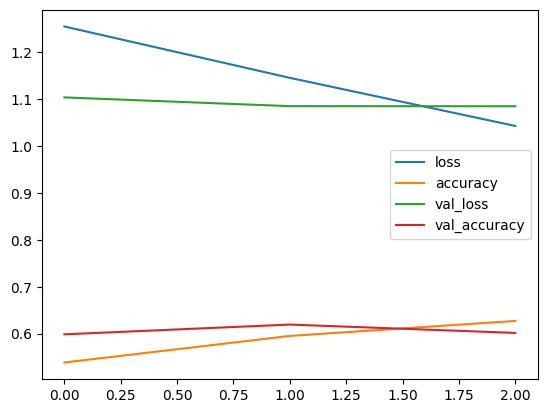

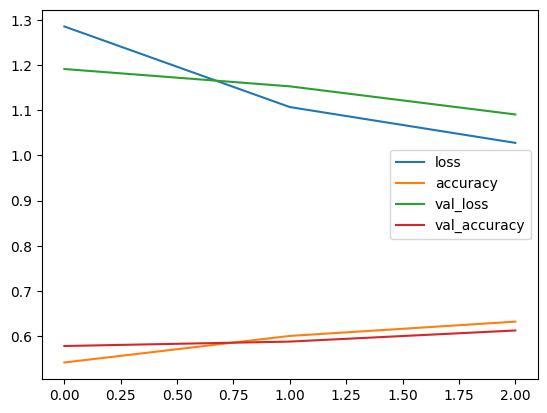

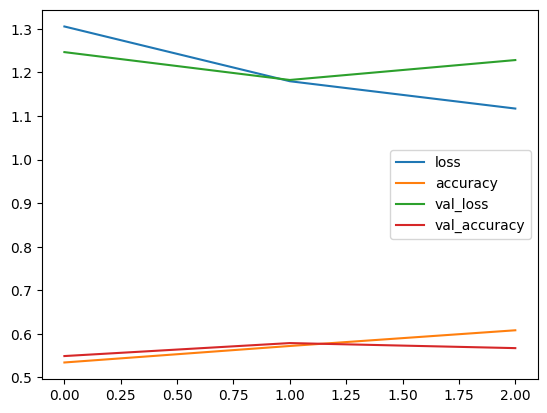

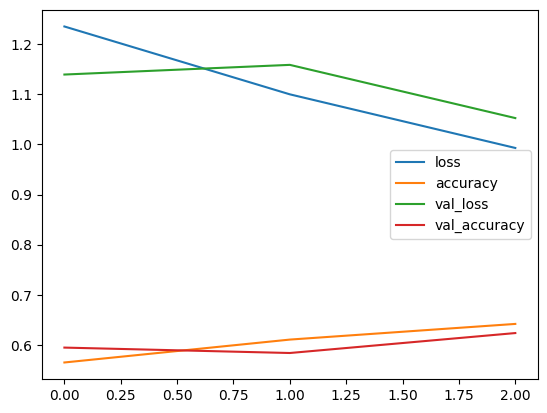

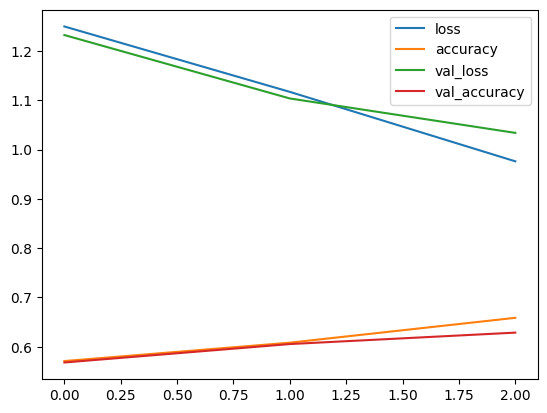

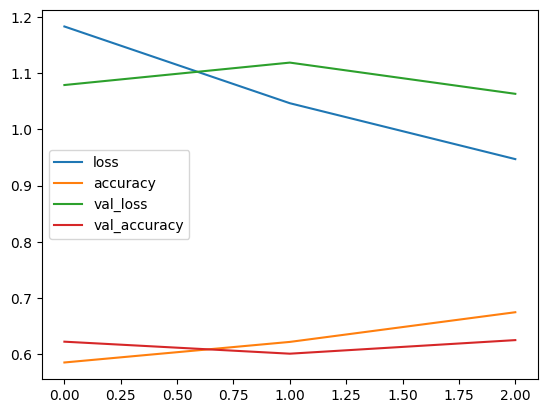

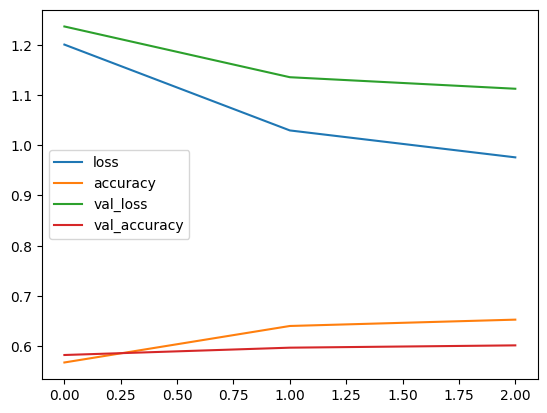

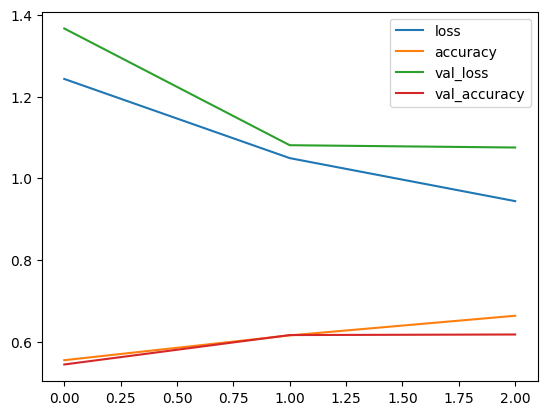

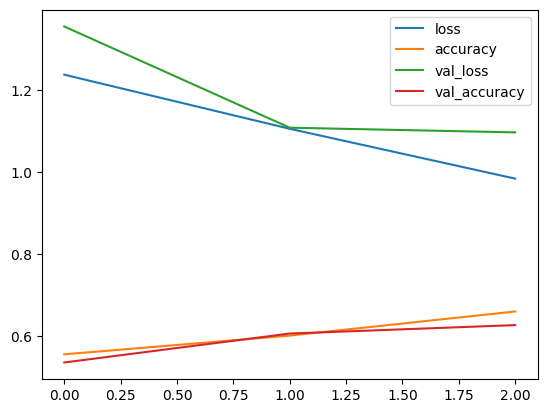

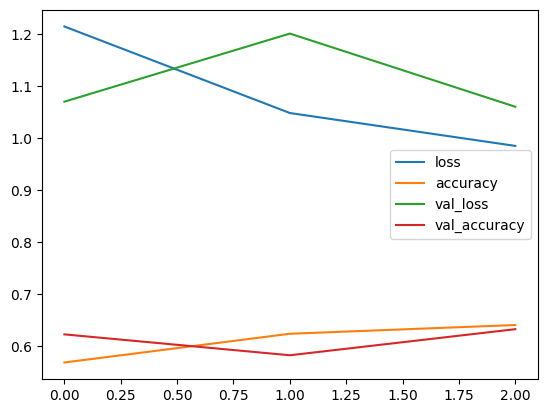

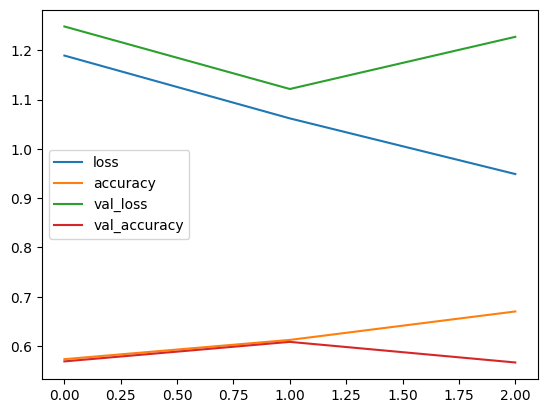

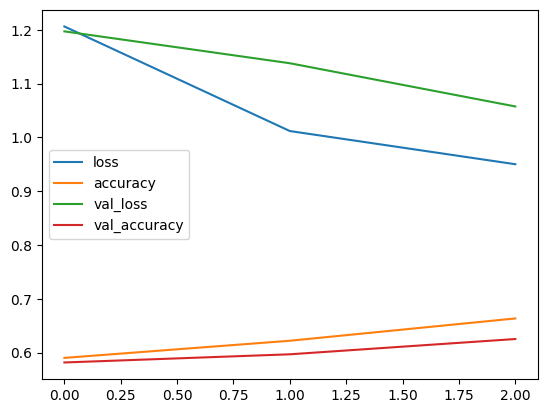

In [ ]:
# remove 100 images from shard 5 all slices one time and get average runtime over all slices
unlearning_times_total = []
acc_losses_total = []
weighted_acc_losses_total = []

avg_unlearning_times = []
avg_acc_losses = []
avg_weighted_acc_losses = []

for i, slice_n in enumerate(slices):
    temp_num_slices = slice_n


    unlearning_times = []
    acc_losses = []
    weighted_acc_losses = []
    for j in range(temp_num_slices):
        unlearning_start_time = time.time()
        # remove 100 images

        shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new = \
        unlearn_data([(5, j, 0, 100)], num_epochs=num_epochs, num_slices=temp_num_slices, validation_accuracies=validation_accs_per_test[i], num_shards=CIFAR_partition_num)
        unlearning_times.append(time.time() - unlearning_start_time)
        acc_losses.append(test_accs[i] - test_acc_new)
        weighted_acc_losses.append(weighted_test_accs[i] - weighted_test_acc_new)
    unlearning_times_total.append(unlearning_times)
    acc_losses_total.append(acc_losses)
    weighted_acc_losses_total.append(weighted_acc_losses)
    avg_unlearning_times.append(np.mean(unlearning_times))
    avg_acc_losses.append(np.mean(acc_losses))
    avg_weighted_acc_losses.append(np.mean(weighted_acc_losses))



#####Plot against num slices

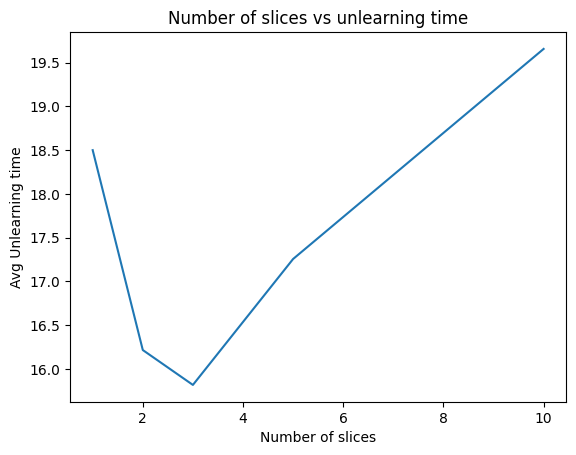

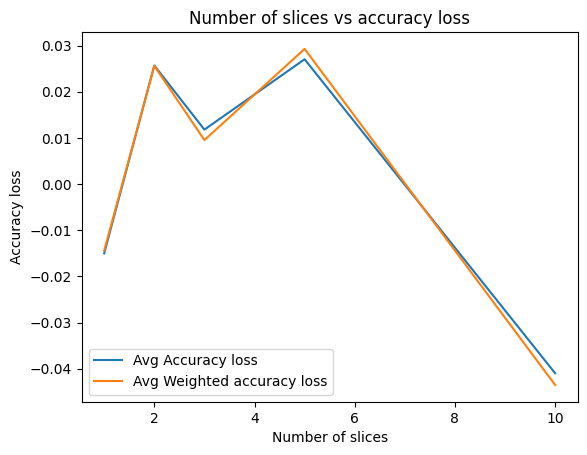

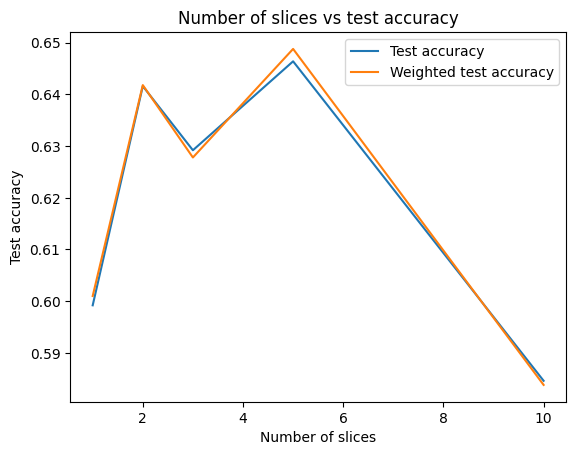

In [ ]:
plt.plot(slices, avg_unlearning_times)
plt.xlabel("Number of slices")
plt.ylabel("Avg Unlearning time")
plt.title("Number of slices vs unlearning time")
plt.show()

# plot num_slices against accuracy loss and weighted accuracy loss
# label lines with accuracy loss and weighted accuracy loss
plt.plot(slices, avg_acc_losses, label="Avg Accuracy loss")
plt.plot(slices, avg_weighted_acc_losses, label="Avg Weighted accuracy loss")


plt.xlabel("Number of slices")
plt.ylabel("Accuracy loss")
plt.title("Number of slices vs accuracy loss")
plt.legend()
plt.show()

# plot num_slices against test accuracy and weighted test accuracy
plt.plot(slices, test_accs, label="Test accuracy")
plt.plot(slices, weighted_test_accs, label="Weighted test accuracy")
plt.xlabel("Number of slices")
plt.ylabel("Test accuracy")
plt.title("Number of slices vs test accuracy")
plt.legend()
plt.show()


##### Plot unlearning time against slice removed from

[32.12863874435425, 29.075568437576294, 26.33737874031067, 23.807676315307617, 20.861730813980103, 18.230921983718872, 15.559067249298096, 12.904419422149658, 10.148459911346436, 7.513999938964844]


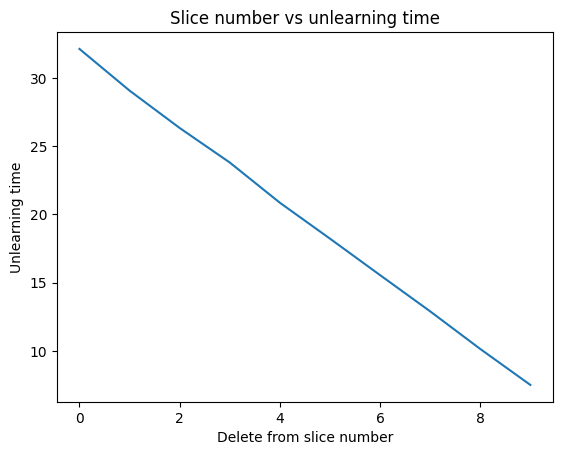

In [ ]:
# plot slice number against unlearning time for run on 10 slices
print(unlearning_times_total[4])
plt.plot(range(10), unlearning_times_total[4])
plt.xlabel("Delete from slice number")
plt.ylabel("Unlearning time")
plt.title("Slice number vs unlearning time")
plt.show()


### Test num_partitions against against unlearning time and accuracy loss

In [ ]:
# plot num_partitions against against unlearning time and accuracy loss

partitions = [1, 2, 5, 10, 20]
unlearning_times = []
acc_losses = []
weighted_acc_losses = []
# remove 2000 images from shard 2 slice 2, 1500 images from shard 3 slice 3, 1000 images from shard 4 slice 1

for i in partitions:
    temp_num_partitions = i
    train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, temp_num_partitions)
    shard_models, validation_accuracies_temp = train_all_shards(temp_num_partitions, num_epochs, num_slices)
    shard_models_prediction_matrix = predict_all_shards(shard_models, temp_num_partitions)
    pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies_temp, temp_num_partitions)
    test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)
    unlearning_start_time = time.time()
    # remove 2000 images from shard 2 slice 2
    shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new = \
    unlearn_data([(2, 2, 0, 2000), (3, 3, 10, 1500), (4, 1, 500, 1000)], num_epochs=num_epochs, num_slices=num_slices, validation_accuracies=validation_accuracies_temp, num_shards=temp_num_partitions)
    unlearning_times.append(time.time() - unlearning_start_time)
    acc_losses.append(test_acc - test_acc_new)
    weighted_acc_losses.append(weighted_test_acc - weighted_test_acc_new)




#### Training

In [ ]:
# split above code into 2 cells: training and unlearning

partitions = [1, 2, 5, 10, 15]
test_accs = []
weighted_test_accs = []
validation_accs_per_test = []


for i in partitions:
    temp_num_partitions = i
    train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, temp_num_partitions)
    shard_models, validation_accuracies_temp = train_all_shards(temp_num_partitions, num_epochs, num_slices)
    shard_models_prediction_matrix = predict_all_shards(shard_models, temp_num_partitions)
    pred_matrix, weighted_pred_matrix = ensemble_predict(shard_models_prediction_matrix, validation_accuracies_temp, temp_num_partitions)
    test_acc, weighted_test_acc = get_accuracy(pred_matrix, CIFAR_test_labels, weighted_pred_matrix)
    test_accs.append(test_acc)
    weighted_test_accs.append(weighted_test_acc)
    validation_accs_per_test.append(validation_accuracies_temp)



size_slice 16666
Training slice number 0
(16666, 32, 32, 3)
Epoch 1/3
521/521 [==============================] - 9s 10ms/step - loss: 2.0252 - accuracy: 0.3272 - val_loss: 1.7970 - val_accuracy: 0.4118
Epoch 2/3
521/521 [==============================] - 5s 9ms/step - loss: 1.4765 - accuracy: 0.4710 - val_loss: 1.2796 - val_accuracy: 0.5506
Epoch 3/3
521/521 [==============================] - 5s 9ms/step - loss: 1.2637 - accuracy: 0.5501 - val_loss: 1.0739 - val_accuracy: 0.6248
Training slice number 1
(16666, 32, 32, 3)
Epoch 1/3
521/521 [==============================] - 5s 9ms/step - loss: 1.1571 - accuracy: 0.5917 - val_loss: 1.2057 - val_accuracy: 0.5992
Epoch 2/3
521/521 [==============================] - 5s 9ms/step - loss: 1.0361 - accuracy: 0.6362 - val_loss: 0.9646 - val_accuracy: 0.6530
Epoch 3/3
521/521 [==============================] - 5s 9ms/step - loss: 0.9508 - accuracy: 0.6697 - val_loss: 0.9067 - val_accuracy: 0.6814
Training slice number 2
Epoch 1/3
521/521 [=======

#### Unlearning

ERROR: shard_num >= num_shards
shard_num 1
num_shards 1
shard_num set to 0
Unlearning shard 0 slice 2 start_index 0 end_index 2000
ERROR: slice_num >= num_slices
slice_num 3
num_slices 3
slice_num set to 2
Unlearning shard 0 slice 2 start_index 10 end_index 1500
ERROR: shard_num >= num_shards
shard_num 2
num_shards 1
shard_num set to 0
Unlearning shard 0 slice 1 start_index 500 end_index 500
ERROR: shard_num >= num_shards
shard_num 2
num_shards 1
shard_num set to 0
Unlearning shard 0 slice 2 start_index 0 end_index 2000
ERROR: shard_num >= num_shards
shard_num 2
num_shards 1
shard_num set to 0
ERROR: slice_num >= num_slices
slice_num 3
num_slices 3
slice_num set to 2
Unlearning shard 0 slice 2 start_index 10 end_index 2000
ERROR: shard_num >= num_shards
shard_num 2
num_shards 1
shard_num set to 0
ERROR: slice_num >= num_slices
slice_num 4
num_slices 3
slice_num set to 2
Unlearning shard 0 slice 2 start_index 0 end_index 2000
size_slice 16000
checkpoint:  -1
retrain slice number 0
(1600

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


size_slice 1000
checkpoint:  -1
retrain slice number 0
(1000, 32, 32, 3)
Epoch 1/3
32/32 [==============================] - 5s 32ms/step - loss: 3.0015 - accuracy: 0.1830 - val_loss: 16.8000 - val_accuracy: 0.1366
Epoch 2/3
32/32 [==============================] - 1s 23ms/step - loss: 2.3505 - accuracy: 0.2760 - val_loss: 4.7414 - val_accuracy: 0.1638
Epoch 3/3
32/32 [==============================] - 1s 23ms/step - loss: 2.2237 - accuracy: 0.3110 - val_loss: 3.1451 - val_accuracy: 0.2532
retrain slice number 1
(1000, 32, 32, 3)
Epoch 1/3
32/32 [==============================] - 1s 26ms/step - loss: 2.3752 - accuracy: 0.2600 - val_loss: 2.0099 - val_accuracy: 0.3514
Epoch 2/3
32/32 [==============================] - 1s 22ms/step - loss: 2.1722 - accuracy: 0.2850 - val_loss: 1.7957 - val_accuracy: 0.3768
Epoch 3/3
32/32 [==============================] - 1s 22ms/step - loss: 1.9672 - accuracy: 0.3450 - val_loss: 1.7868 - val_accuracy: 0.3780
retrain slice number 2
Epoch 1/3
32/32 [=====

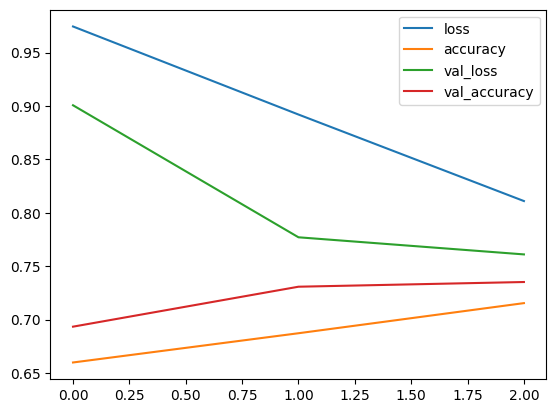

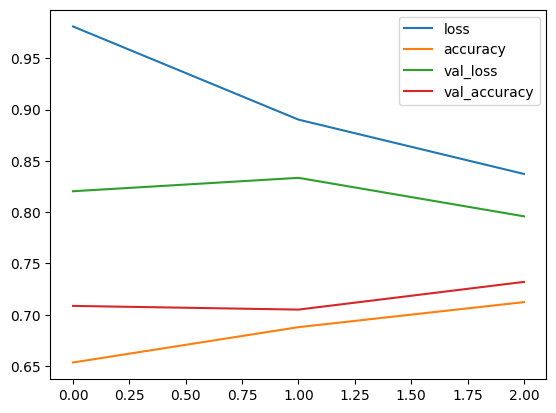

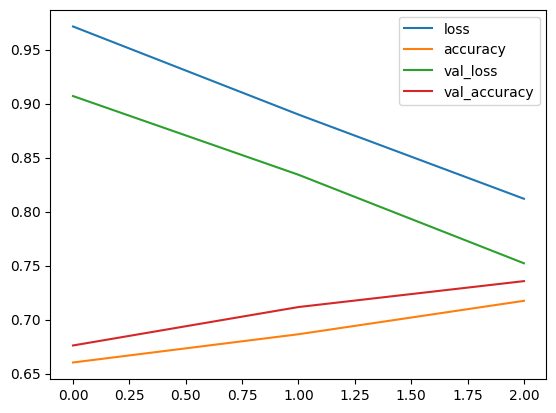

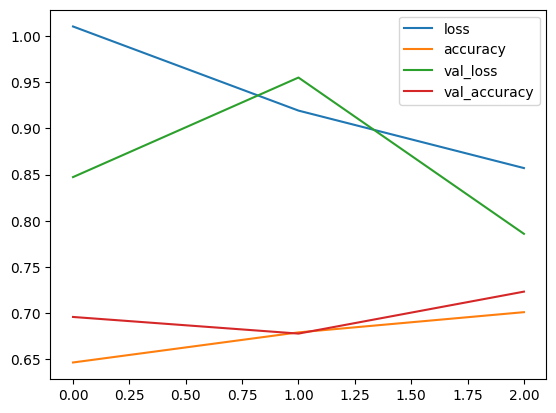

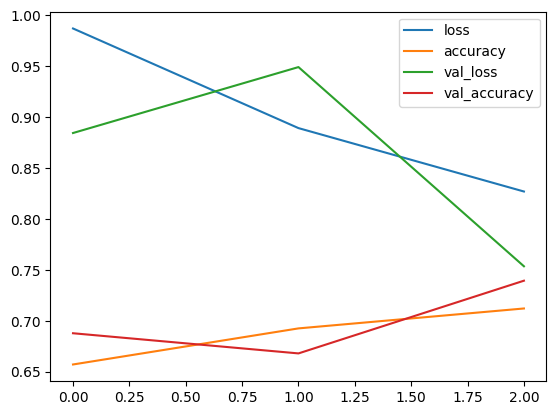

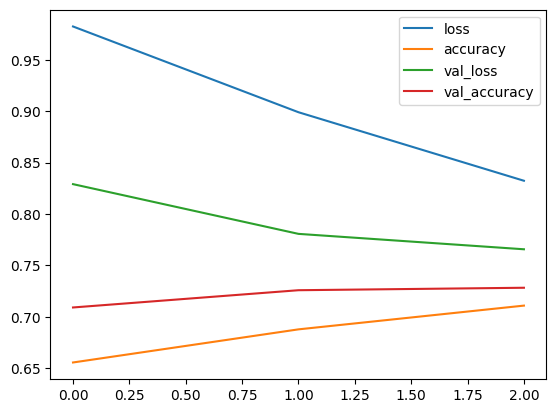

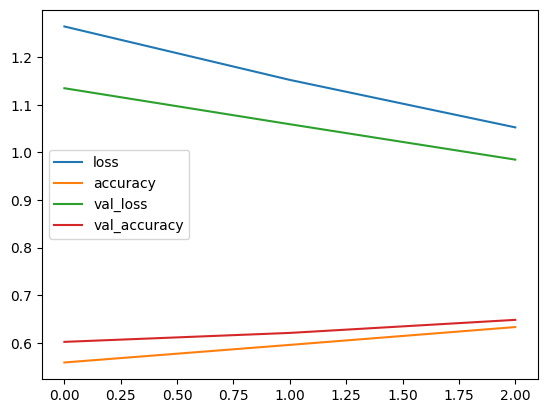

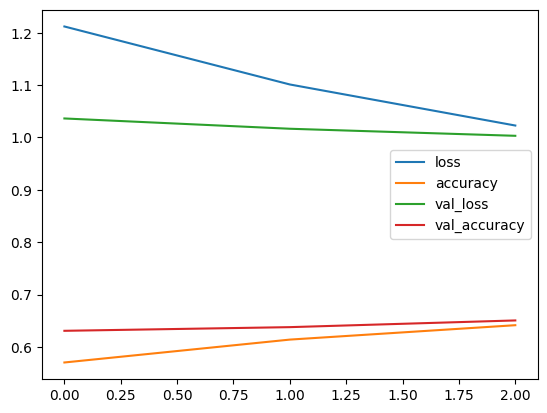

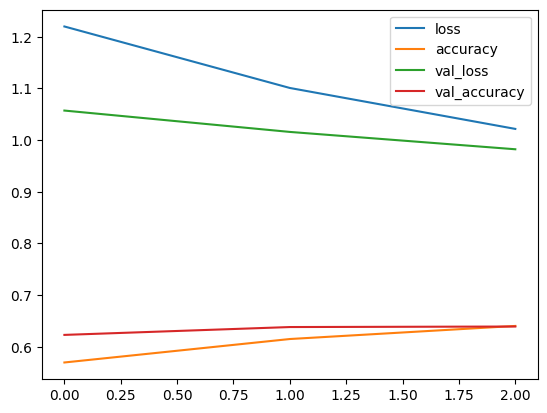

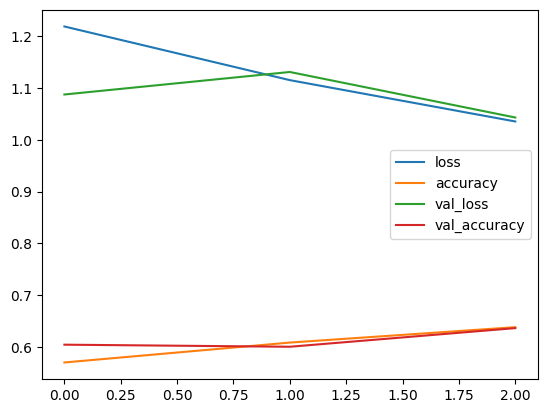

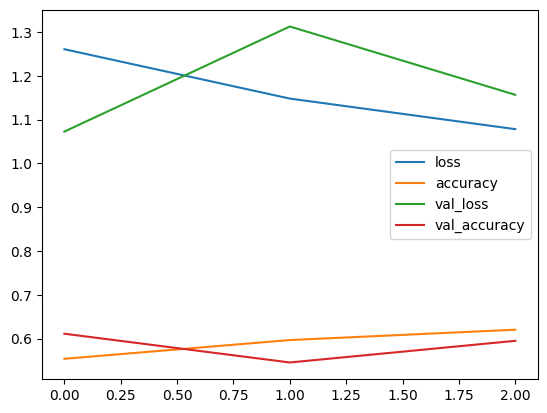

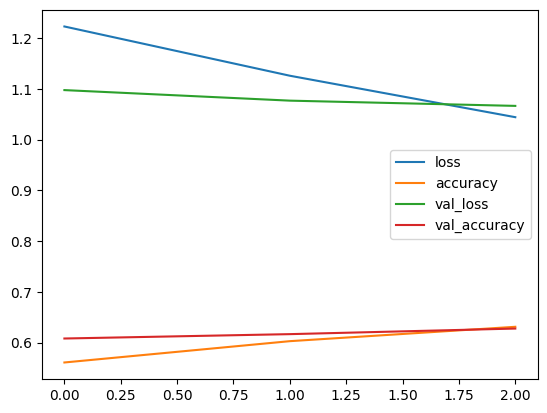

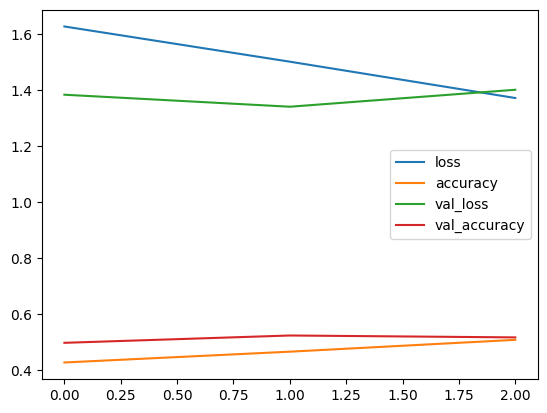

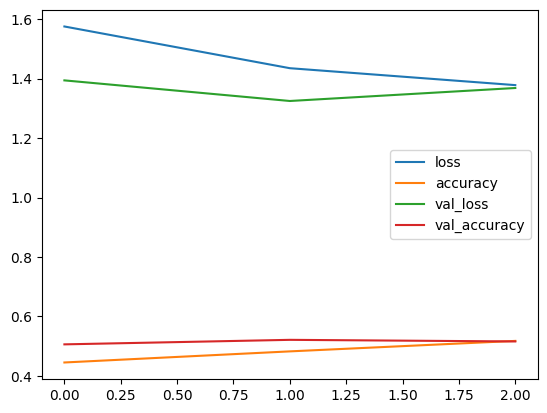

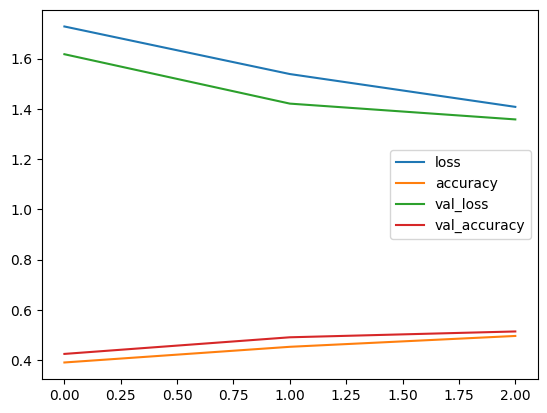

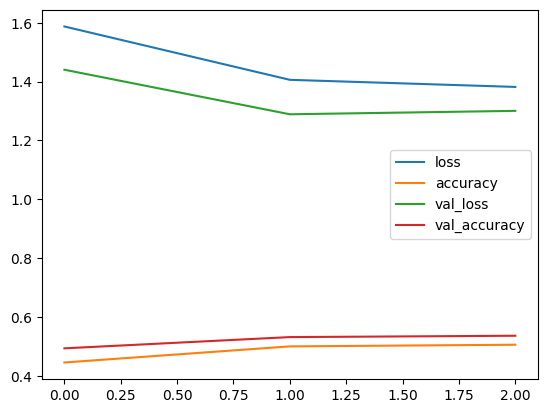

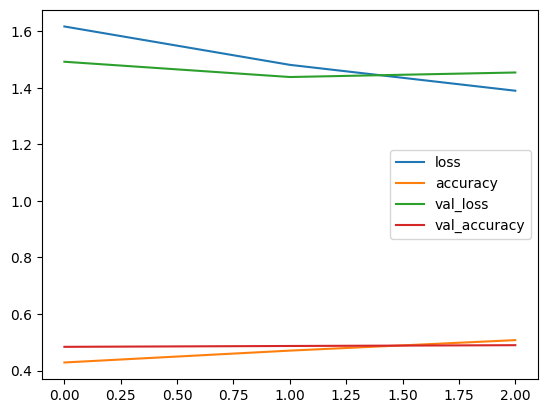

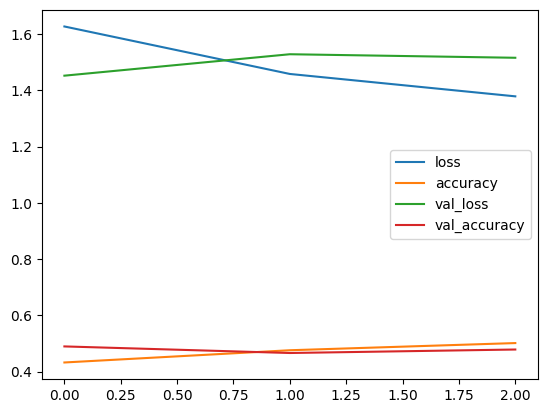

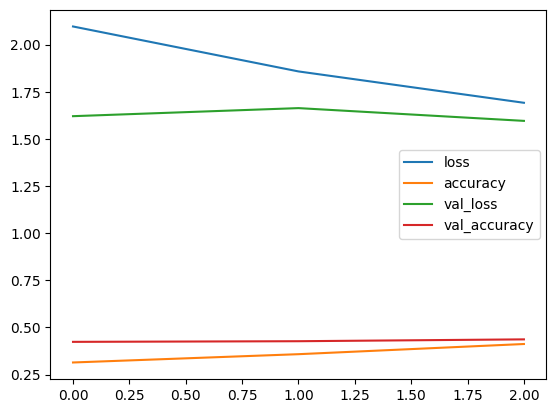

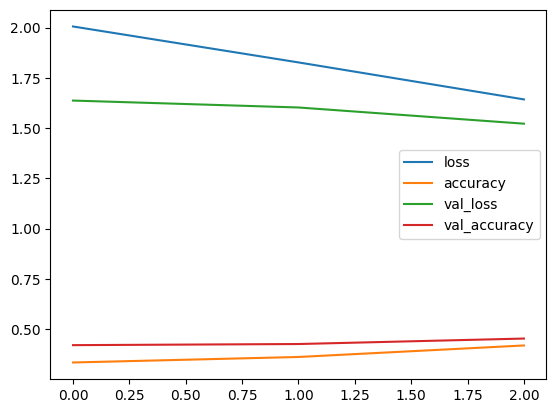

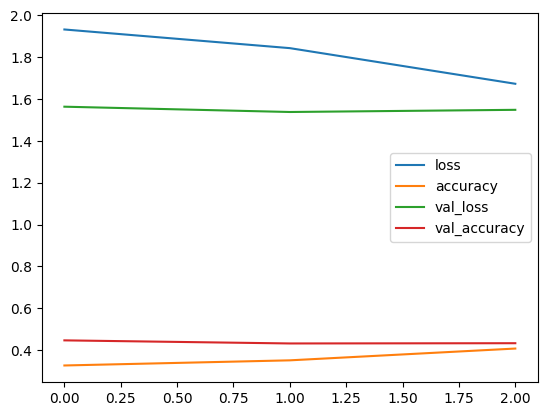

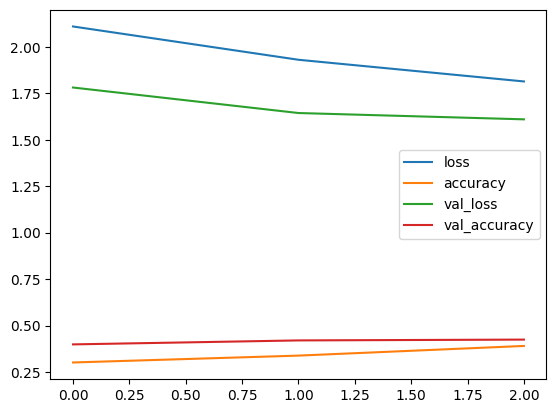

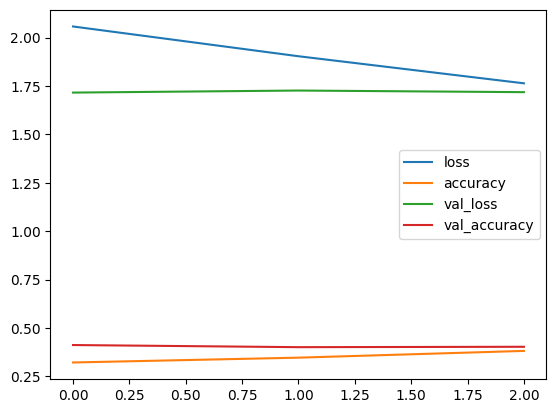

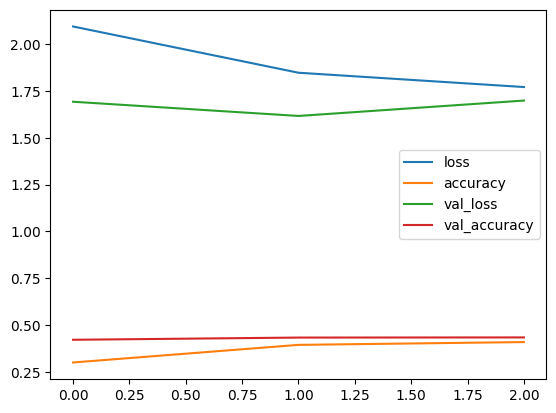

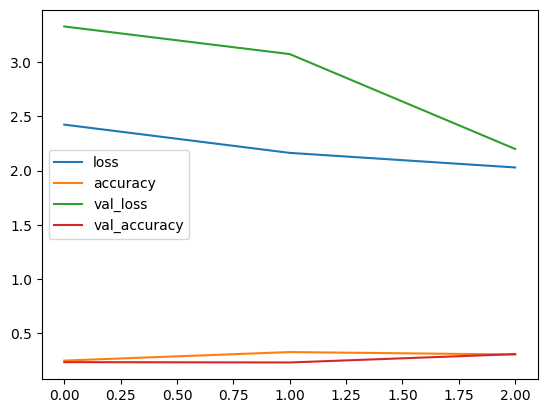

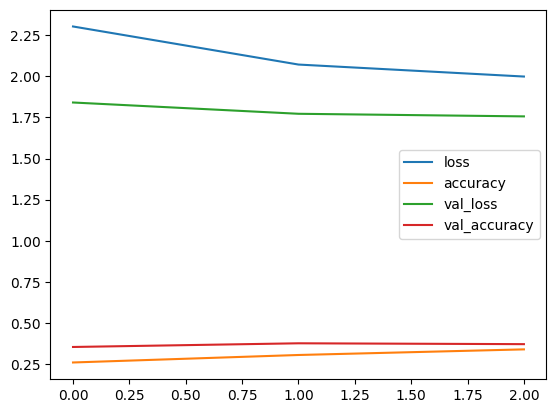

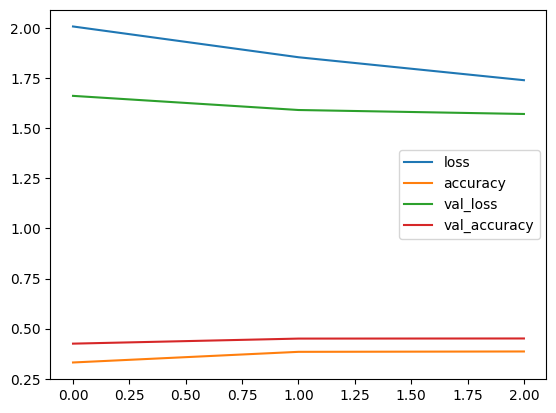

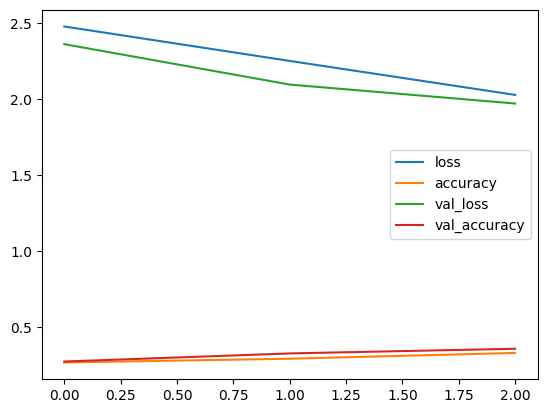

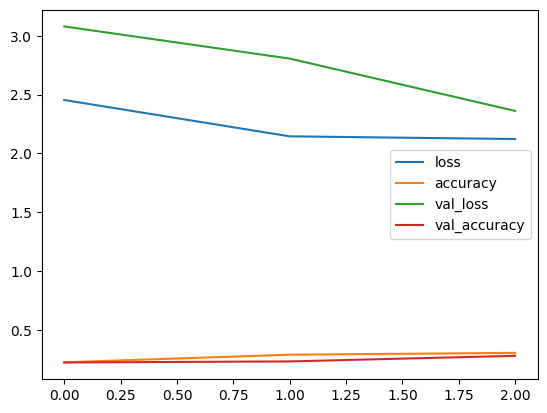

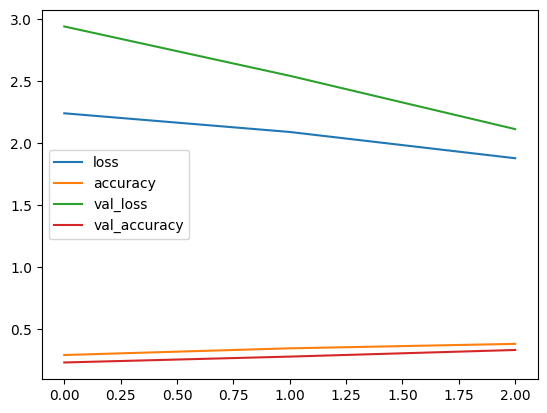

In [ ]:
unlearning_times = []
acc_losses = []
weighted_acc_losses = []

for i, partition_n in enumerate(partitions):
    temp_num_partitions = partition_n
    train_data_CIFAR_partitioned = partition_data(train_images_CIFAR, train_labels_CIFAR, temp_num_partitions)

    unlearning_start_time = time.time()
    shard_models_revised, train_data_CIFAR_partitioned_revised, validation_accuracies_new, test_acc_new, weighted_test_acc_new = \
    unlearn_data([(1, 2, 0, 2000), (0, 3, 10, 1500), (2, 1, 500, 500), (2, 2, 0, 2000), (2, 3, 10, 2000), (2, 4, 0, 2000)], num_epochs=num_epochs, num_slices=num_slices, validation_accuracies=validation_accs_per_test[i], num_shards=temp_num_partitions)
    unlearning_times.append(time.time() - unlearning_start_time)
    acc_losses.append(test_accs[i] - test_acc_new)
    weighted_acc_losses.append(weighted_test_accs[i] - weighted_test_acc_new)

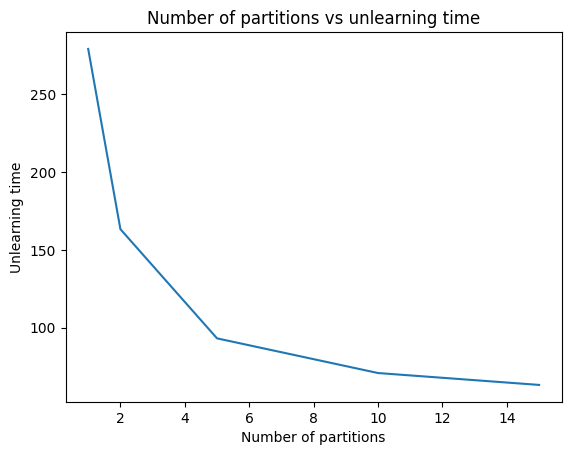

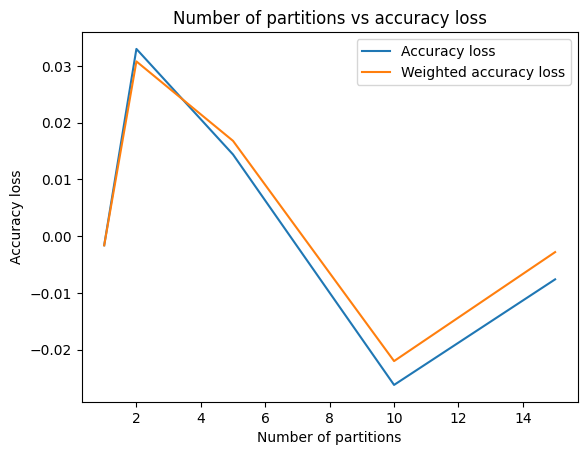

In [ ]:
plt.plot(partitions, unlearning_times)
plt.xlabel("Number of partitions")
plt.ylabel("Unlearning time")
plt.title("Number of partitions vs unlearning time")
plt.show()

# plot num_partitions against accuracy loss and weighted accuracy loss
# label lines with accuracy loss and weighted accuracy loss
plt.plot(partitions, acc_losses, label="Accuracy loss")
plt.plot(partitions, weighted_acc_losses, label="Weighted accuracy loss")
plt.xlabel("Number of partitions")
plt.ylabel("Accuracy loss")
plt.title("Number of partitions vs accuracy loss")
plt.legend()
plt.show()

## Results

# References

1.   List item
2.   List item

